In [1]:
import os
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
import torch.nn.functional as F
from losses import edl_mse_loss

from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
from tqdm.auto import tqdm

from dataset import TextDataset 
from losses import edl_mse_loss

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

import time

tic, toc = (time.time, time.time)

In [2]:
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-13b-chat-hf", use_auth_token=True)
model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-2-13b-chat-hf", use_auth_token=True)
model.half().cuda();
model.eval();

/n/home04/yidachen/.conda/envs/diffusion-viz-gpu/lib/python3.9/site-packages/transformers/models/auto/tokenization_auto.py:729: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
/n/home04/yidachen/.conda/envs/diffusion-viz-gpu/lib/python3.9/site-packages/transformers/models/auto/auto_factory.py:468: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
from probes import ProbeClassification, ProbeClassificationMixScaler
    
class TrainerConfig:
    # optimization parameters
    max_epochs = 10
    batch_size = 64
    learning_rate = 1e-3
    betas = (0.9, 0.95)
    grad_norm_clip = 1.0
    weight_decay = 0.1 # only applied on matmul weights
    # learning rate decay params: linear warmup followed by cosine decay to 10% of original
    lr_decay = False
    # checkpoint settings
    ckpt_path = None
    num_workers = 0 # for DataLoader

    def __init__(self, **kwargs):
        for k,v in kwargs.items():
            setattr(self, k, v)

In [4]:
from train_test_utils import train, test 
import torch.nn as nn

In [5]:
from probes import ProbeClassification, ProbeClassificationMixScaler

# New Stuff

## Linear Probing on All Attributes

### Use this setting

### BCE loss

In [6]:
import os
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
import torch.nn.functional as F

import torch
from tqdm.auto import tqdm
from collections import OrderedDict


class ModuleHook:
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)
        self.module = None
        self.features = []

    def hook_fn(self, module, input, output):
        self.module = module
        self.features.append(output.detach())

    def close(self):
        self.hook.remove()
        
        
def remove_last_k_words(s, k):
    """
    Remove the last k words from the string s.
    Any words that appear before the last occurrence of "[INST]" will not be removed.
    """
    
    # Split string into words
    words = s.split()
    
    # Find the last occurrence of "[INST]"
    if "[/INST]" in words:
        last_inst_index = max([i for i, word in enumerate(words) if word == "[/INST]"])
    else:
        last_inst_index = -1
    
    # If k words to be removed are less than words after last INST, remove those words.
    # Otherwise, keep the words up to and including INST and remove words after that.
    if len(words) - last_inst_index - 1 > k:
        return ' '.join(words[:-k])
    else:
        return ' '.join(words[:last_inst_index+1])
        

def split_conversation(text, user_identifier="HUMAN:", ai_identifier="ASSISTANT:"):
    user_messages = []
    assistant_messages = []

    lines = text.split("\n")

    current_user_message = ""
    current_assistant_message = ""

    for line in lines:
        line = line.lstrip(" ")
        if line.startswith(user_identifier):
            if current_assistant_message:
                assistant_messages.append(current_assistant_message.strip())
                current_assistant_message = ""
            current_user_message += line.replace(user_identifier, "").strip() + " "
        elif line.startswith(ai_identifier):
            if current_user_message:
                user_messages.append(current_user_message.strip())
                current_user_message = ""
            current_assistant_message += line.replace(ai_identifier, "").strip() + " "

    if current_user_message:
        user_messages.append(current_user_message.strip())
    if current_assistant_message:
        assistant_messages.append(current_assistant_message.strip())

    return user_messages, assistant_messages


def llama_v2_prompt(
    messages: list[dict],
    system_prompt=None
):
    B_INST, E_INST = "[INST]", "[/INST]"
    B_SYS, E_SYS = "<<SYS>>\n", "\n<</SYS>>\n\n"
    BOS, EOS = "<s>", "</s>"
    if system_prompt:
        DEFAULT_SYSTEM_PROMPT = system_prompt
    else:
        DEFAULT_SYSTEM_PROMPT = f"""You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe. Please ensure that your responses are socially unbiased and positive in nature. If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information."""

    if messages[0]["role"] != "system":
        messages = [
            {
                "role": "system",
                "content": DEFAULT_SYSTEM_PROMPT,
            }
        ] + messages
    messages = [
        {
            "role": messages[1]["role"],
            "content": B_SYS + messages[0]["content"] + E_SYS + messages[1]["content"],
        }
    ] + messages[2:]

    messages_list = [
        f"{BOS}{B_INST} {(prompt['content']).strip()} {E_INST} {(answer['content']).strip()} {EOS}"
        for prompt, answer in zip(messages[::2], messages[1::2])
    ]
    messages_list.append(f"{BOS}{B_INST} {(messages[-1]['content']).strip()} {E_INST}")

    return "".join(messages_list)  


class TextDataset(Dataset):
    def __init__(self, directory, tokenizer, model, label_idf="_age_", label_to_id=None, 
                 convert_to_llama2_format=False, user_identifier="HUMAN:", ai_identifier="ASSISTANT:",
                 additional_datas=None, residual_stream=False, new_format=False, if_augmented=False, k=20,
                 remove_last_ai_response=False, include_inst=False, one_hot=False, last_tok_pos=-1):
        self.file_paths = [os.path.join(directory, f) for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f)) and f.endswith('.txt')]
        self.tokenizer = tokenizer
        self.labels = []
        self.acts = []
        self.texts = []
        self.label_idf = label_idf
        self.label_to_id = label_to_id
        self.model = model
        self.convert_to_llama2_format = convert_to_llama2_format
        self.user_identifier = user_identifier
        self.ai_identifier = ai_identifier
        self.additional_datas = additional_datas
        self.residual_stream = residual_stream
        self.new_format = new_format
        self.if_augmented = if_augmented
        self.k = k
        self.if_remove_last_ai_response = remove_last_ai_response
        self.include_inst = include_inst
        self.one_hot = one_hot
        self.last_tok_pos = last_tok_pos
        if self.additional_datas:
            for directory in self.additional_datas:
                self.file_paths += [os.path.join(directory, f) for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f)) and f.endswith('.txt')]
        self._load_in_data()

    def __len__(self):
        return len(self.texts)
    
    def _load_in_data(self):
        for idx in tqdm(range(len(self.file_paths))):
            file_path = self.file_paths[idx]
            corrupted_file_paths = []
            with open(file_path, 'r', encoding='utf-8') as f:
                text = f.read()
            if self.convert_to_llama2_format:
                if "openai" in file_path:
                    if "### Human:" in text:
                        user_msgs, ai_msgs = split_conversation(text, "### Human:", "### Assistant:")
                    elif "### Human：" in text:
                        user_msgs, ai_msgs = split_conversation(text, "### Human：", "### Assistant：")
                    elif "### Ассистент:" in text:
                        user_msgs, ai_msgs = split_conversation(text, "### Человек:", "### Ассистент:")
                    elif "### Помощник:" in text:
                        user_msgs, ai_msgs = split_conversation(text, "### Человек:", "### Помощник:")
                    elif "### 人間：" in text:
                        user_msgs, ai_msgs = split_conversation(text, "### 人間：", "### アシスタント：")
                    elif "### アシスタント:" in text:
                        user_msgs, ai_msgs = split_conversation(text, "### 人間:", "### アシスタント:")
                    elif "### 人：" in text:
                        user_msgs, ai_msgs = split_conversation(text, "### 人：", "### 助手：")
                    elif "### 人:" in text:
                        user_msgs, ai_msgs = split_conversation(text, "### 人:", "### 助手:")
                    elif "### 机器人助手:" in text:
                        user_msgs, ai_msgs = split_conversation(text, "### 人类:", "### 机器人助手:")
                    elif "### 助手：" in text:
                        user_msgs, ai_msgs = split_conversation(text, "### 人类：", "### 助手：")
                    elif "### 助手:" in text:
                        user_msgs, ai_msgs = split_conversation(text, "### 人类:", "### 助手:")
                    elif "### 机器人:" in text:    
                        user_msgs, ai_msgs = split_conversation(text, "### 人类:", "### 机器人:")
                    elif "### Assistente:" in text:
                        user_msgs, ai_msgs = split_conversation(text, "### Humano:", "### Assistente:")
                    elif "### Asistente:" in text:
                        user_msgs, ai_msgs = split_conversation(text, "### Humano:", "### Asistente:")
                    elif "### Mensch:" in text:
                        user_msgs, ai_msgs = split_conversation(text, "### Mensch:", "### Assistent:")
                    else:
                        user_msgs, ai_msgs = split_conversation(text, "### User:", "### Assistant:")
                else:
                    user_msgs, ai_msgs = split_conversation(text, self.user_identifier, self.ai_identifier)
                messages_dict = []

                for user_msg, ai_msg in zip(user_msgs, ai_msgs):
                    messages_dict.append({'content': user_msg, 'role': 'user'})
                    messages_dict.append({'content': ai_msg, 'role': 'assistant'})
                    
                if len(messages_dict) < 1:
                    corrupted_file_paths.append(file_path)
                    print(f"Corrupted file at {file_path}")
                    continue
                    
                if self.if_remove_last_ai_response and messages_dict[-1]["role"] == "assistant":
                    messages_dict = messages_dict[:-1]
                try:
                    text = llama_v2_prompt(messages_dict) 
                except:
                    corrupted_file_paths.append(file_path)
                    print(f"Corrupted file at {file_path}")
                    continue
              
            if self.new_format and self.if_remove_last_ai_response and self.include_inst:
                text = text[text.find("<s>") + len("<s>"):]
            elif self.new_format and self.include_inst:
                text = text[text.find("<s>") + len("<s>"):]
            elif self.new_format:
                text = text[text.find("<s>") + len("<s>"): text.rfind("[/INST]") - 1]
            
            # if self.if_augmented:
            #     random_k = torch.randint(0, self.k, [1])[0].item()
            #     text = remove_last_k_words(text, random_k)
            
            label = file_path[file_path.rfind(self.label_idf) + len(self.label_idf):file_path.rfind(".txt")]
            
            if label not in self.label_to_id.keys():
                continue
                
            if self.label_to_id:
                label = self.label_to_id[label]
                
            if self.one_hot:
                label = F.one_hot(torch.Tensor([label]).to(torch.long), len(self.label_to_id.keys()))
                
            
            # text += f" I think the {self.label_idf[1:-1]} of this user is"
            with torch.no_grad():
                encoding = self.tokenizer(
                  text,
                  truncation=True,
                  max_length=2048,
                  return_attention_mask=True,
                  return_tensors='pt'
                )
                
                features = OrderedDict()
                for name, module in self.model.named_modules():
                    if name.endswith(".mlp") or name.endswith(".embed_tokens"):
                        features[name] = ModuleHook(module)
                        
                output = self.model(input_ids=encoding['input_ids'].to("cuda"),
                                    attention_mask=encoding['attention_mask'].to("cuda"),
                                    output_hidden_states=True,
                                    return_dict=True)
                for feature in features.values():
                    feature.close()
            
            last_acts = []
            if self.if_augmented:
                if self.residual_stream:
                    for layer_num in range(41):
                        last_acts.append(output["hidden_states"][layer_num][:, -self.k:].detach().cpu().clone().to(torch.float))
                    last_acts = torch.cat(last_acts, dim=0)
                else:
                    last_acts.append(features['model.embed_tokens'].features[0][:, -self.k:].detach().cpu().clone().to(torch.float))
                    for layer_num in range(1, 41):
                        last_acts.append(features[f'model.layers.{layer_num - 1}.mlp'].features[0][:, -self.k:].detach().cpu().clone().to(torch.float))
                    last_acts = torch.cat(last_acts, dim=0)
            else:
                if self.residual_stream:
                    for layer_num in range(41):
                        last_acts.append(output["hidden_states"][layer_num][:, -1].detach().cpu().clone().to(torch.float))
                    last_acts = torch.cat(last_acts)
                else:
                    last_acts.append(features['model.embed_tokens'].features[0][:, -1].detach().cpu().clone().to(torch.float))
                    for layer_num in range(1, 41):
                        last_acts.append(features[f'model.layers.{layer_num - 1}.mlp'].features[0][:, -1].detach().cpu().clone().to(torch.float))
                    last_acts = torch.cat(last_acts)
            
            self.texts.append(text)
            self.labels.append(label)
            self.acts.append(last_acts)
            
        for path in corrupted_file_paths:
            self.file_paths.remove(path)
    def __getitem__(self, idx):
        label = self.labels[idx]
        text = self.texts[idx]
 
        if self.if_augmented:
            random_k = torch.randint(0, self.k, [1])[0].item()
            hidden_states = self.acts[idx][:, -random_k]
        else:
            hidden_states = self.acts[idx]
        
        return {
            'hidden_states': hidden_states,
            'file_path': self.file_paths[idx],
            'age': label,
            'text': text,
        }

    
class JsonDataset(Dataset):
    def __init__(self, json, tokenizer, model, label_idf=["right_response", 'hallucinated_response'], 
                 label_to_id={'hallucinated_response': 0, 'right_response': 1}, 
                 convert_to_llama2_format=False, user_identifier="[Human]:", ai_identifier="[Assistant]:",
                 additional_jsons=None, residual_stream=False, new_format=False, if_augmented=False, k=5,
                 remove_last_ai_response=False, include_inst=False, one_hot=False, last_tok_pos=-2):
        self.json_paths = [json]
        if additional_jsons:
            self.json_paths += additional_jsons
        self.tokenizer = tokenizer
        self.labels = []
        self.acts = []
        self.texts = []
        self.label_idf = label_idf
        self.label_to_id = label_to_id
        self.model = model
        self.convert_to_llama2_format = convert_to_llama2_format
        self.user_identifier = user_identifier
        self.ai_identifier = ai_identifier
        self.additional_datas = additional_jsons
        self.residual_stream = residual_stream
        self.new_format = new_format
        self.if_augmented = if_augmented
        self.k = k
        self.if_remove_last_ai_response = remove_last_ai_response
        self.include_inst = include_inst
        self.one_hot = one_hot
        self.last_tok_pos = last_tok_pos
        self._load_in_data()

    def __len__(self):
        return len(self.texts)
    
    def _load_in_data(self):
        data = []
        for i in range(len(self.json_paths)):
            with open(self.json_paths[i], 'r', encoding="utf-8") as f:
                for line in f:
                    data.append(json.loads(line))
                    
        # for idx in tqdm(range(len(data))):
        for idx in tqdm(range(10000)):
            for label in label_idf:
                text = data[idx]['dialogue_history'] + f" {self.ai_identifier}: {data[idx][label]}"
                text = text.replace(" [", "\n[")
                if self.convert_to_llama2_format:
                    user_msgs, ai_msgs = split_conversation(text, self.user_identifier, self.ai_identifier)
                    messages_dict = []

                    for user_msg, ai_msg in zip(user_msgs, ai_msgs):
                        messages_dict.append({'content': user_msg, 'role': 'user'})
                        messages_dict.append({'content': ai_msg, 'role': 'assistant'})

                    if len(messages_dict) < 1:
                        print(f"Corrupted sample at {idx}")
                        continue

                    if self.if_remove_last_ai_response and messages_dict[-1]["role"] == "assistant":
                        messages_dict = messages_dict[:-1]
                    try:
                        text = llama_v2_prompt(messages_dict)
                    except:
                        print(f"Corrupted sample at {idx}")
                        continue

                if self.new_format and self.if_remove_last_ai_response and self.include_inst:
                    text = text[text.find("<s>") + len("<s>"):]
                elif self.new_format and self.include_inst:
                    text = text[text.find("<s>") + len("<s>"):]
                elif self.new_format:
                    text = text[text.find("<s>") + len("<s>"): text.rfind("[/INST]") - 1]

                # if self.if_augmented:
                #     random_k = torch.randint(0, self.k, [1])[0].item()
                #     text = remove_last_k_words(text, random_k)

                if label not in self.label_to_id.keys():
                    continue

                if self.label_to_id:
                    label = self.label_to_id[label]

                if self.one_hot:
                    label = F.one_hot(torch.Tensor([label]).to(torch.long), len(self.label_to_id.keys()))
                
                with torch.no_grad():
                    encoding = self.tokenizer(
                      text,
                      truncation=True,
                      max_length=2048,
                      return_attention_mask=True,
                      return_tensors='pt'
                    )

                    features = OrderedDict()
                    for name, module in self.model.named_modules():
                        if name.endswith(".mlp") or name.endswith(".embed_tokens"):
                            features[name] = ModuleHook(module)

                    output = self.model(input_ids=encoding['input_ids'].to("cuda"),
                                        attention_mask=encoding['attention_mask'].to("cuda"),
                                        output_hidden_states=True,
                                        return_dict=True)
                    for feature in features.values():
                        feature.close()

                last_acts = []
                if self.if_augmented:
                    if self.residual_stream:
                        for layer_num in range(41):
                            last_acts.append(output["hidden_states"][layer_num][:, -self.k:].detach().cpu().clone().to(torch.float))
                        last_acts = torch.cat(last_acts, dim=0)
                    else:
                        last_acts.append(features['model.embed_tokens'].features[0][:, -self.k:].detach().cpu().clone().to(torch.float))
                        for layer_num in range(1, 41):
                            last_acts.append(features[f'model.layers.{layer_num - 1}.mlp'].features[0][:, -self.k:].detach().cpu().clone().to(torch.float))
                        last_acts = torch.cat(last_acts, dim=0)
                else:
                    if self.residual_stream:
                        for layer_num in range(41):
                            last_acts.append(output["hidden_states"][layer_num][:, self.last_tok_pos].detach().cpu().clone().to(torch.float))
                        last_acts = torch.cat(last_acts)
                    else:
                        last_acts.append(features['model.embed_tokens'].features[0][:, self.last_tok_pos].detach().cpu().clone().to(torch.float))
                        for layer_num in range(1, 41):
                            last_acts.append(features[f'model.layers.{layer_num - 1}.mlp'].features[0][:, self.last_tok_pos].detach().cpu().clone().to(torch.float))
                        last_acts = torch.cat(last_acts)

                self.texts.append(text)
                self.labels.append(label)
                self.acts.append(last_acts)

    def __getitem__(self, idx):
        label = self.labels[idx]
        text = self.texts[idx]
 
        if self.if_augmented:
            random_k = torch.randint(0, self.k, [1])[0].item()
            hidden_states = self.acts[idx][:, -random_k]
        else:
            hidden_states = self.acts[idx]
        
        return {
            'hidden_states': hidden_states,
            'age': label,
            'text': text,
        }
    

### Sklearn Unregularized Probes

  0%|          | 0/5000 [00:00<?, ?it/s]

Corrupted file at datasets/openai_age_additional/conversation_650_age_adolescent.txt
Corrupted file at datasets/openai_age_additional/conversation_735_age_older adult.txt
Corrupted file at datasets/openai_age_additional/conversation_740_age_child.txt
Corrupted file at datasets/openai_age_other/conversation_998_age_unknown.txt
Corrupted file at datasets/openai_age_other/conversation_485_age_unknown.txt
Corrupted file at datasets/openai_age_other/conversation_811_age_unknown.txt
{'hidden_states': tensor([[-0.0059,  0.0280, -0.0031,  ...,  0.0097,  0.0249, -0.0065],
        [-0.0279,  0.0608, -0.0051,  ...,  0.0305,  0.0289, -0.0174],
        [-0.0582,  0.1135, -0.0185,  ...,  0.0153,  0.0355,  0.0112],
        ...,
        [-0.2324, -0.2148, -0.1565,  ..., -2.3945,  1.2363,  2.2188],
        [-0.2168, -0.6543, -0.7100,  ..., -2.0410,  1.3418,  2.5508],
        [-0.2151, -0.8223, -0.0641,  ..., -0.8564,  0.1229,  1.3477]]), 'file_path': 'datasets_llama2/age/conversation_87_age_adult.txt',

/n/home04/yidachen/.conda/envs/diffusion-viz-gpu/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


Best Accuracy: 0.959


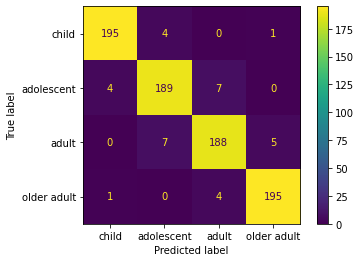

/n/home04/yidachen/.conda/envs/diffusion-viz-gpu/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


Best Accuracy: 0.961


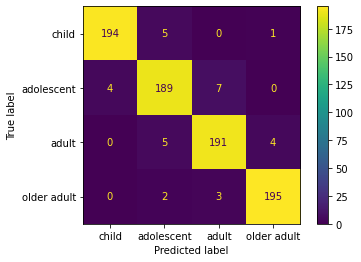

/n/home04/yidachen/.conda/envs/diffusion-viz-gpu/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


Best Accuracy: 0.963


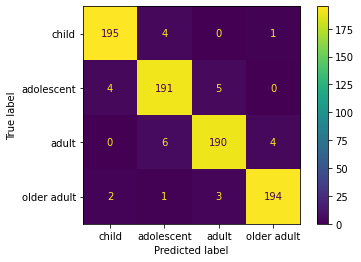

/n/home04/yidachen/.conda/envs/diffusion-viz-gpu/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


Best Accuracy: 0.965


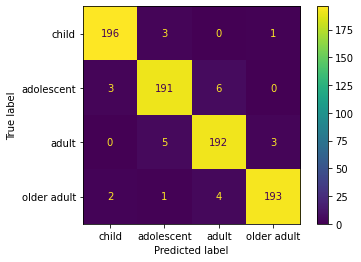

/n/home04/yidachen/.conda/envs/diffusion-viz-gpu/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


Best Accuracy: 0.968


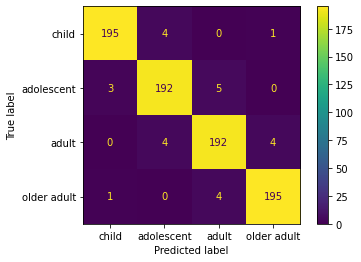

/n/home04/yidachen/.conda/envs/diffusion-viz-gpu/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


Best Accuracy: 0.959


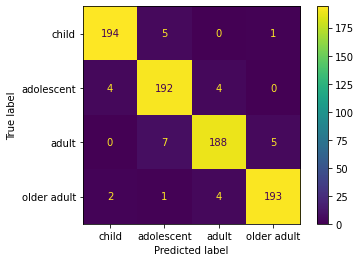

/n/home04/yidachen/.conda/envs/diffusion-viz-gpu/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


Best Accuracy: 0.963


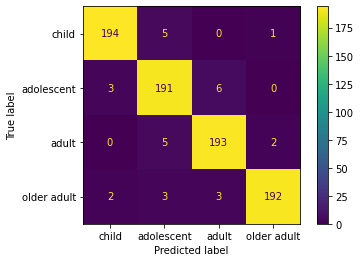

/n/home04/yidachen/.conda/envs/diffusion-viz-gpu/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


Best Accuracy: 0.961


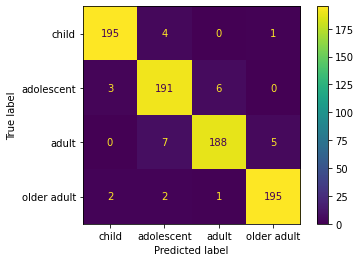

/n/home04/yidachen/.conda/envs/diffusion-viz-gpu/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


Best Accuracy: 0.965


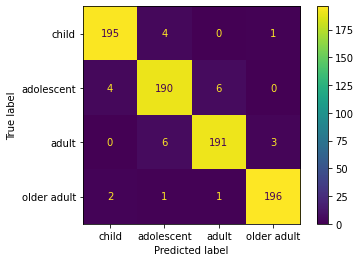

/n/home04/yidachen/.conda/envs/diffusion-viz-gpu/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


Best Accuracy: 0.969


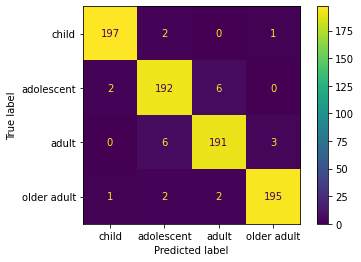

/n/home04/yidachen/.conda/envs/diffusion-viz-gpu/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


Best Accuracy: 0.969


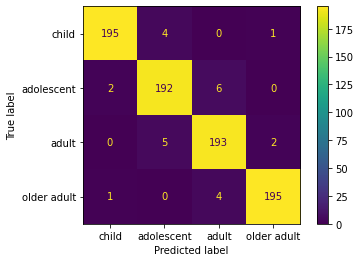

/n/home04/yidachen/.conda/envs/diffusion-viz-gpu/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


Best Accuracy: 0.968


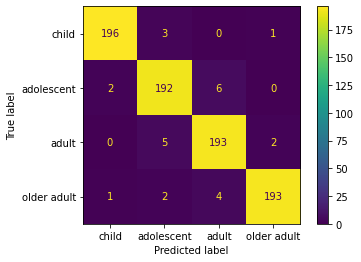

  0%|          | 0/6000 [00:00<?, ?it/s]

Corrupted file at datasets/openai_education_three_classes/conversation_207_education_someschool.txt
Corrupted file at datasets/openai_education_three_classes/conversation_210_education_highschool.txt
Corrupted file at datasets/openai_education_three_classes/conversation_19_education_collegemore.txt
Corrupted file at datasets/openai_education_three_classes/conversation_223_education_someschool.txt
Corrupted file at datasets/openai_education_three_classes_even_more/conversation_1369_education_highschool.txt
Corrupted file at datasets/openai_education_three_classes_even_more/conversation_1450_education_someschool.txt
Corrupted file at datasets/openai_education_unknown/conversation_1127_education_unknown.txt
Corrupted file at datasets/openai_education_unknown/conversation_584_education_unknown.txt
Corrupted file at datasets/openai_education_unknown/conversation_740_education_unknown.txt
Corrupted file at datasets/openai_education_unknown/conversation_370_education_unknown.txt
Corrupted fil

/n/home04/yidachen/.conda/envs/diffusion-viz-gpu/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/n/home04/yidachen/.conda/envs/diffusion-viz-gpu/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best Accuracy: 0.910


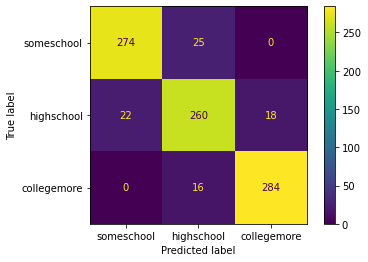

/n/home04/yidachen/.conda/envs/diffusion-viz-gpu/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/n/home04/yidachen/.conda/envs/diffusion-viz-gpu/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best Accuracy: 0.934


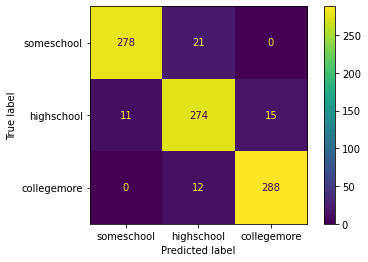

/n/home04/yidachen/.conda/envs/diffusion-viz-gpu/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/n/home04/yidachen/.conda/envs/diffusion-viz-gpu/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best Accuracy: 0.928


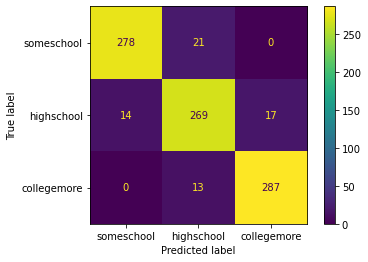

/n/home04/yidachen/.conda/envs/diffusion-viz-gpu/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/n/home04/yidachen/.conda/envs/diffusion-viz-gpu/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best Accuracy: 0.927


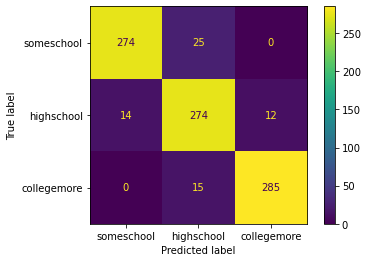

/n/home04/yidachen/.conda/envs/diffusion-viz-gpu/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/n/home04/yidachen/.conda/envs/diffusion-viz-gpu/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best Accuracy: 0.939


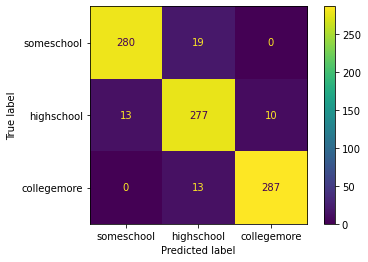

/n/home04/yidachen/.conda/envs/diffusion-viz-gpu/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/n/home04/yidachen/.conda/envs/diffusion-viz-gpu/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best Accuracy: 0.934


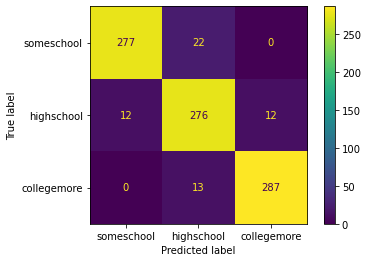

/n/home04/yidachen/.conda/envs/diffusion-viz-gpu/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/n/home04/yidachen/.conda/envs/diffusion-viz-gpu/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best Accuracy: 0.937


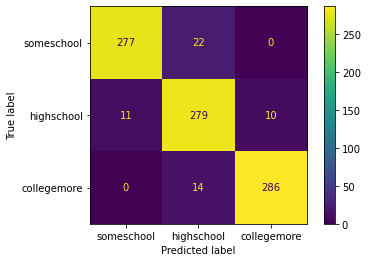

/n/home04/yidachen/.conda/envs/diffusion-viz-gpu/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/n/home04/yidachen/.conda/envs/diffusion-viz-gpu/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best Accuracy: 0.941


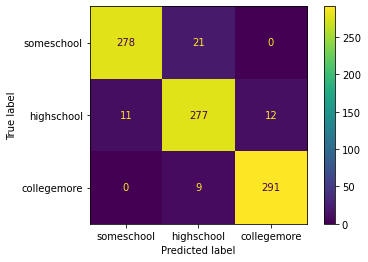

/n/home04/yidachen/.conda/envs/diffusion-viz-gpu/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/n/home04/yidachen/.conda/envs/diffusion-viz-gpu/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best Accuracy: 0.933


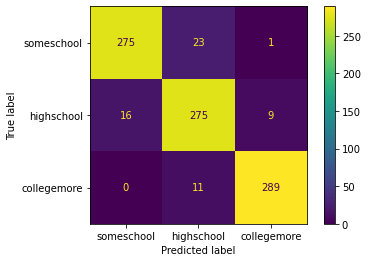

/n/home04/yidachen/.conda/envs/diffusion-viz-gpu/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/n/home04/yidachen/.conda/envs/diffusion-viz-gpu/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best Accuracy: 0.937


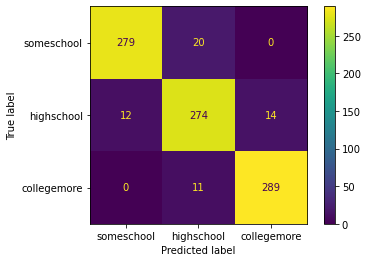

/n/home04/yidachen/.conda/envs/diffusion-viz-gpu/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/n/home04/yidachen/.conda/envs/diffusion-viz-gpu/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best Accuracy: 0.917


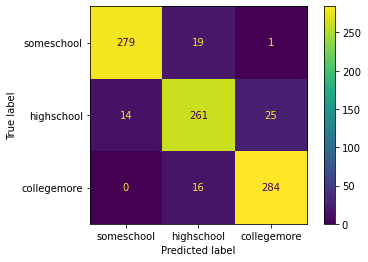

/n/home04/yidachen/.conda/envs/diffusion-viz-gpu/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/n/home04/yidachen/.conda/envs/diffusion-viz-gpu/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best Accuracy: 0.937


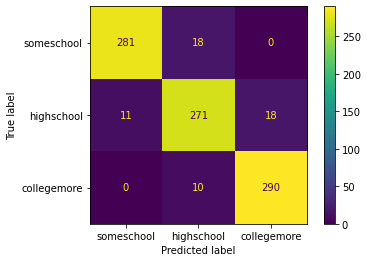

In [7]:
from probes import LinearProbeClassification, LinearProbeClassificationMixScaler
from sklearn.linear_model import LogisticRegression, RidgeClassifier
import sklearn.model_selection
import pickle
import numpy as np

new_prompt_format=True
residual_stream=True
uncertainty = False
logistic = True
augmented = False
remove_last_ai_response = True
include_inst = True
one_hot = True

label_to_id_age = {"child": 0,
                   "adolescent": 1,
                   "adult": 2,
                   "older adult": 3,}

label_to_id_gender = {"male": 0,
                      "female": 1,
                      "other": 2}

label_to_id_ethnicity = {"asian": 0, 
                         "african": 1,
                         "white": 2,
                         "hispanic": 3,
                         "native_americans": 4,
                         "arabs": 5,
                         "jews": 6,}

label_to_id_socioeconomic = {"low": 0,
                             "middle": 1,
                             "high": 2,
                             # "unknown": 3
                            }

# label_to_id_marital = {"single": 0,
#                        "married": 1,
#                        "separated": 2,
#                        "divorced": 3,
#                        "widowed": 4,}

label_to_id_marital = {"single": 0,
                       "married": 1,
                       "divorced": 2,
                       "widowed": 3,}

label_to_id_language = {"Chinese": 0,
                        "Japanese": 1,
                        "English": 2,
                        "German": 3,
                        "Spanish": 4,
                        "Portuguese": 5,
                        "Arabic": 6,
                        "Russian": 7, 
                       }

label_to_id_neweducation = {"someschool": 0,
                            "highschool": 1,
                            "collegemore": 2,}

label_to_id_religion = {"christianity":0,
                        "islam":1, 
                        "Buddhism":2, 
                        "hinduism":3, 
                        "judaism": 4,
                        "atheism": 5,
                       }


label_to_id_political = {"left-wing":0,
                         "right-wing":1, 
                         "moderate":2}


prompt_translator = {"_age_": "age",
                     "_gender_": "gender",
                     "_ethnics_": "ethnicity",
                     "_socioeco_": "socioeconomic status",
                     "_marital_": "marital status",
                     "_language_": "spoken language",
                     "_education_": "education level",
                     "_religion_": "religious belief",
                     "_political_": "political view"}

openai_dataset = {"_age_": "datasets/openai_age/",
                  "_gender_": "datasets/openai_gender/",
                  "_education_": "datasets/openai_education/",
                  "_ethnics_": "datasets/openai_ethnics/",
                  "_socioeco_": "datasets/openai_socioeconomic_challenging/",
                  "_marital_": "datasets/openai_martial_status/"}


accuracy_dict = {}


directories = ["datasets_llama2/age/", "datasets/openai_education_three_classes/",]

label_idfs = ["_age_", "_education_",]

label_to_ids = [label_to_id_age, label_to_id_neweducation,]


for directory, label_idf, label_to_id in zip(directories, label_idfs, label_to_ids):
    # additional_dataset=[directory[:-1] + "_additional/"]
    if label_idf == "_education_" or label_idf == "_language_" or label_idf == "_religion_" or label_idf == "_political_":
        additional_dataset=[]
    else:
        additional_dataset=[directory[:-1] + "_additional/", openai_dataset[label_idf]]
    if label_idf == "_gender_":
        additional_dataset += ["datasets/openai_gender_additional/", 
                               # "datasets/openai_gender_even_more/", 
                               # "datasets/openai_gender_explicit",
                               # "datasets/openai_gender_other_unknown/",
                               "datasets/openai_gpt4_gender",
                              ]
    if label_idf == "_education_":
        additional_dataset += ["datasets/openai_education_three_classes_additional/", "datasets/openai_education_three_classes_even_more/",
                               "datasets/openai_education_unknown/", "datasets/openai_education_unknown_other/"]
    if label_idf == "_socioeco_":
        additional_dataset += ["datasets/openai_socioeconomic_additional/", 
                               # "datasets/openai_socioeconomic_other/"
                              ]
    if label_idf == "_marital_":
        additional_dataset += ["datasets/openai_marital_status_additional/"]
    if label_idf == "_age_":
        additional_dataset += ["datasets/openai_age_additional/", "datasets/openai_age_other/"]
    if label_idf == "_ethnics_":
        additional_dataset += ["datasets/openai_ethnics_unknown/"]
    if label_idf == "_political_":
        additional_dataset += ["datasets/openai_political_even_more/",
                               "datasets/openai_political_further_more/",
                               "datasets/openai_political_even_further_more/"]
    dataset = TextDataset(directory, tokenizer, model, label_idf=label_idf, label_to_id=label_to_id,
                          convert_to_llama2_format=True, additional_datas=additional_dataset, 
                          new_format=new_prompt_format,
                          residual_stream=residual_stream, if_augmented=augmented, 
                          remove_last_ai_response=remove_last_ai_response, include_inst=include_inst, k=1,
                          one_hot=False, last_tok_pos=-1)
    # break
    print(dataset[0])
    print(len(dataset))
    dict_name = label_idf.strip("_")
    # if dict_name == "marital" or dict_name == "religion":
    #     dict_name = "new" + dict_name
    # dict_name = "known" + dict_name
    print("-" * 40 + dict_name + "-" * 40)
    torch.manual_seed(12345)

    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    # train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
    train_idx, val_idx = sklearn.model_selection.train_test_split(list(range(len(dataset))), 
                                                                  test_size=test_size,
                                                                  train_size=train_size,
                                                                  random_state=12345,
                                                                  shuffle=True,
                                                                  stratify=dataset.labels)

    train_dataset = Subset(dataset, train_idx)
    test_dataset = Subset(dataset, val_idx)

    sampler = None
    train_loader = DataLoader(train_dataset, shuffle=True, sampler=sampler, pin_memory=True, batch_size=200, num_workers=1)
    test_loader = DataLoader(test_dataset, shuffle=False, pin_memory=True, batch_size=400, num_workers=1)

    if uncertainty:
        loss_func = edl_mse_loss
    else:
        loss_func = nn.BCELoss()
    torch_device = "cuda"

    accs = []
    for i in range(19, 31):
        layer_num = i
        trainer_config = TrainerConfig()
        X = torch.concat(train_dataset.dataset.acts, axis=0).view(-1, 41, 5120).numpy()[train_idx]
        y = np.array(train_dataset.dataset.labels)[train_idx]
        X_test = torch.concat(test_dataset.dataset.acts, axis=0).view(-1, 41, 5120).numpy()[val_idx]
        y_test = np.array(test_dataset.dataset.labels)[val_idx]
        clf = LogisticRegression(random_state=0, multi_class="ovr", solver="lbfgs", penalty="none", C=1e5).fit(X[:, i], y)
        # clf = RidgeClassifier(random_state=0, solver="auto").fit(X[:, i], y)
        trainer_config = TrainerConfig()
        probe = LinearProbeClassification(probe_class=len(label_to_id.keys()), device="cuda", input_dim=5120,
                                          logistic=logistic)
        with torch.no_grad():
            probe.proj[0].weight = torch.nn.Parameter(torch.Tensor(clf.coef_).to("cuda"))
            probe.proj[0].bias = torch.nn.Parameter(torch.Tensor(clf.intercept_).to("cuda"))
            torch.save(probe.state_dict(), f"probe_checkpoints/sklearn_comparison_probe_even_more/{dict_name}_probe_at_layer_{layer_num}.pth")

        best_acc = clf.score(X_test[:, i], y_test)
        print(f"Best Accuracy: {best_acc:.3f}")
        accs.append(best_acc)
        cm = confusion_matrix(y_test, clf.predict(X_test[:, i]))
        cm_display = ConfusionMatrixDisplay(cm, display_labels=label_to_id.keys()).plot()
        plt.show()
        
    accuracy_dict[dict_name] = accs
    del dataset, train_dataset, test_dataset, train_loader, test_loader
    torch.cuda.empty_cache()
    
    
# with open("output_scores_with_special_prompt_with_unknown.pkl", "wb") as outfile:
#     pickle.dump(accuracy_dict, outfile)

### New Gender

  0%|          | 0/5000 [00:00<?, ?it/s]

Corrupted file at datasets/openai_age_additional/conversation_650_age_adolescent.txt
Corrupted file at datasets/openai_age_additional/conversation_735_age_older adult.txt
Corrupted file at datasets/openai_age_additional/conversation_740_age_child.txt
Corrupted file at datasets/openai_age_other/conversation_998_age_unknown.txt
Corrupted file at datasets/openai_age_other/conversation_485_age_unknown.txt
Corrupted file at datasets/openai_age_other/conversation_811_age_unknown.txt
{'hidden_states': tensor([[-0.0059,  0.0280, -0.0031,  ...,  0.0097,  0.0249, -0.0065],
        [-0.0279,  0.0608, -0.0051,  ...,  0.0305,  0.0289, -0.0174],
        [-0.0582,  0.1135, -0.0185,  ...,  0.0153,  0.0355,  0.0112],
        ...,
        [-0.2324, -0.2148, -0.1565,  ..., -2.3945,  1.2363,  2.2188],
        [-0.2168, -0.6543, -0.7100,  ..., -2.0410,  1.3418,  2.5508],
        [-0.2151, -0.8223, -0.0641,  ..., -0.8564,  0.1229,  1.3477]]), 'file_path': 'datasets_llama2/age/conversation_87_age_adult.txt',

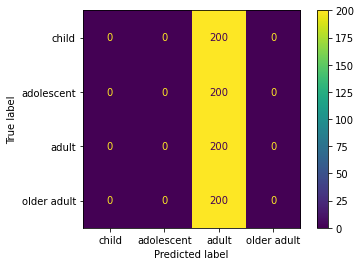

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 1----------------------------------------

Train set: Average loss: 0.5706 (2.915 sec) Accuracy: 0.447

Test set: Average loss: 0.5707,  Accuracy: 0.448

Best Accuracy: 0.605


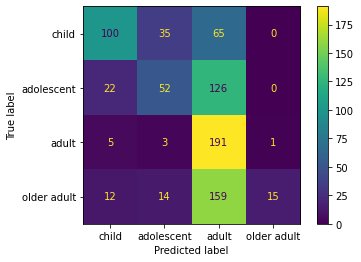

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 2----------------------------------------

Train set: Average loss: 0.5607 (2.913 sec) Accuracy: 0.595

Test set: Average loss: 0.5608,  Accuracy: 0.601

Best Accuracy: 0.609


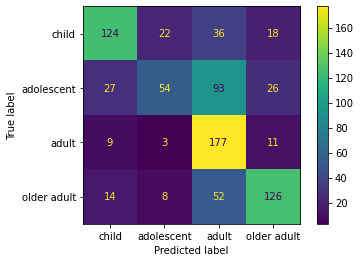

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 3----------------------------------------

Train set: Average loss: 0.5535 (2.902 sec) Accuracy: 0.594

Test set: Average loss: 0.5536,  Accuracy: 0.601

Best Accuracy: 0.604


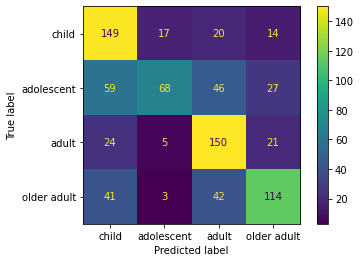

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 4----------------------------------------

Train set: Average loss: 0.5448 (2.905 sec) Accuracy: 0.637

Test set: Average loss: 0.5450,  Accuracy: 0.627

Best Accuracy: 0.646


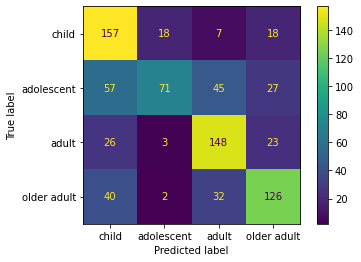

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 5----------------------------------------

Train set: Average loss: 0.5256 (2.901 sec) Accuracy: 0.672

Test set: Average loss: 0.5259,  Accuracy: 0.645

Best Accuracy: 0.664


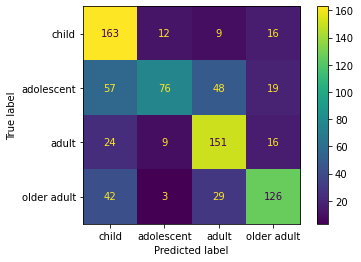

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 6----------------------------------------

Train set: Average loss: 0.5014 (2.901 sec) Accuracy: 0.711

Test set: Average loss: 0.5015,  Accuracy: 0.723

Best Accuracy: 0.743


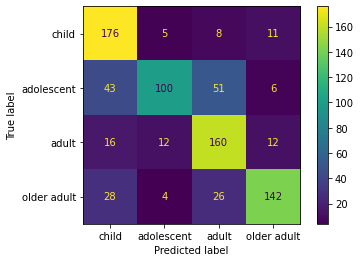

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 7----------------------------------------

Train set: Average loss: 0.4553 (2.905 sec) Accuracy: 0.797

Test set: Average loss: 0.4558,  Accuracy: 0.810

Best Accuracy: 0.823


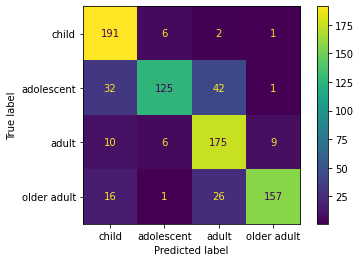

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 8----------------------------------------

Train set: Average loss: 0.4181 (2.909 sec) Accuracy: 0.810

Test set: Average loss: 0.4179,  Accuracy: 0.819

Best Accuracy: 0.836


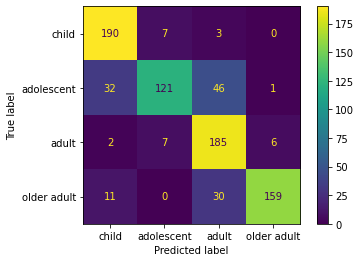

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 9----------------------------------------

Train set: Average loss: 0.3854 (2.905 sec) Accuracy: 0.815

Test set: Average loss: 0.3849,  Accuracy: 0.826

Best Accuracy: 0.835


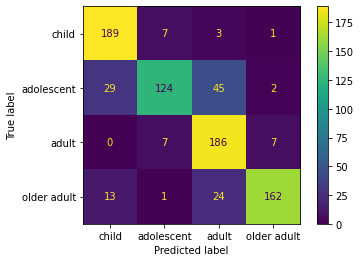

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 10----------------------------------------

Train set: Average loss: 0.3735 (2.903 sec) Accuracy: 0.821

Test set: Average loss: 0.3724,  Accuracy: 0.835

Best Accuracy: 0.846


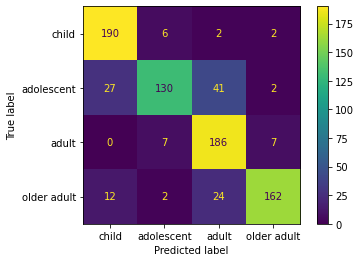

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 11----------------------------------------

Train set: Average loss: 0.3496 (2.952 sec) Accuracy: 0.850

Test set: Average loss: 0.3494,  Accuracy: 0.859

Best Accuracy: 0.864


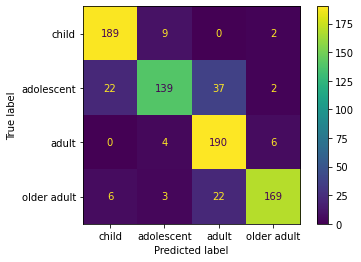

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 12----------------------------------------

Train set: Average loss: 0.3453 (3.037 sec) Accuracy: 0.847

Test set: Average loss: 0.3454,  Accuracy: 0.860

Best Accuracy: 0.864


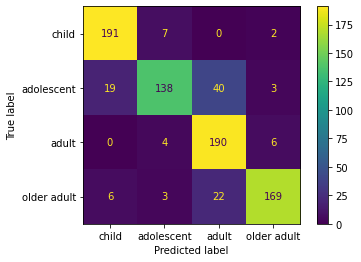

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 13----------------------------------------

Train set: Average loss: 0.3220 (3.024 sec) Accuracy: 0.868

Test set: Average loss: 0.3212,  Accuracy: 0.879

Best Accuracy: 0.885


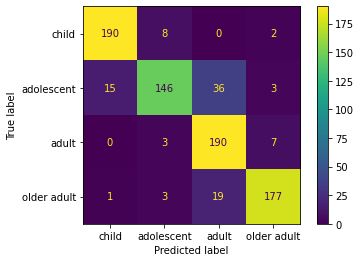

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 14----------------------------------------

Train set: Average loss: 0.2851 (3.022 sec) Accuracy: 0.883

Test set: Average loss: 0.2834,  Accuracy: 0.881

Best Accuracy: 0.892


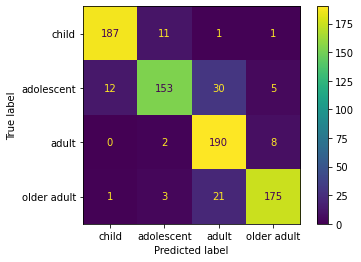

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 15----------------------------------------

Train set: Average loss: 0.2585 (3.042 sec) Accuracy: 0.894

Test set: Average loss: 0.2556,  Accuracy: 0.906

Best Accuracy: 0.907


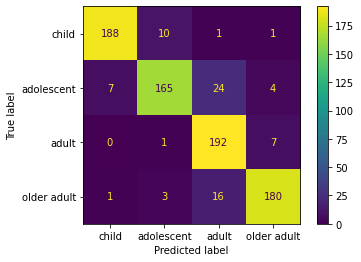

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 16----------------------------------------

Train set: Average loss: 0.2258 (3.040 sec) Accuracy: 0.913

Test set: Average loss: 0.2228,  Accuracy: 0.909

Best Accuracy: 0.917


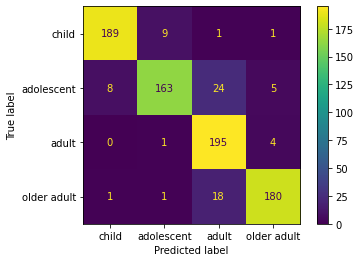

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 17----------------------------------------

Train set: Average loss: 0.2075 (3.063 sec) Accuracy: 0.917

Test set: Average loss: 0.2036,  Accuracy: 0.919

Best Accuracy: 0.926


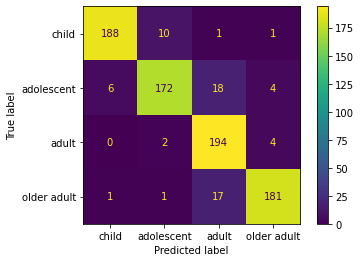

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 18----------------------------------------

Train set: Average loss: 0.1988 (3.054 sec) Accuracy: 0.920

Test set: Average loss: 0.1949,  Accuracy: 0.917

Best Accuracy: 0.924


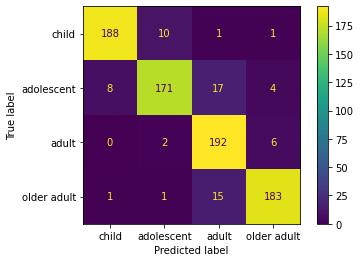

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 19----------------------------------------

Train set: Average loss: 0.1873 (3.058 sec) Accuracy: 0.926

Test set: Average loss: 0.1839,  Accuracy: 0.927

Best Accuracy: 0.929


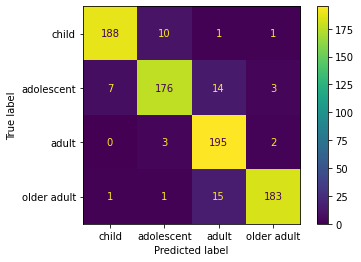

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 20----------------------------------------

Train set: Average loss: 0.1675 (3.207 sec) Accuracy: 0.936

Test set: Average loss: 0.1649,  Accuracy: 0.939

Best Accuracy: 0.939


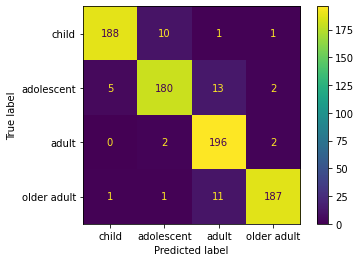

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 21----------------------------------------

Train set: Average loss: 0.1573 (3.143 sec) Accuracy: 0.940

Test set: Average loss: 0.1563,  Accuracy: 0.938

Best Accuracy: 0.940


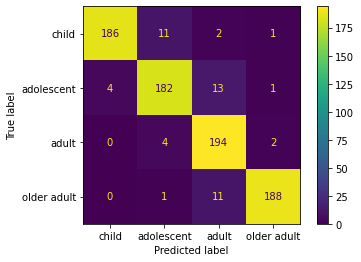

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 22----------------------------------------

Train set: Average loss: 0.1365 (3.149 sec) Accuracy: 0.948

Test set: Average loss: 0.1361,  Accuracy: 0.938

Best Accuracy: 0.941


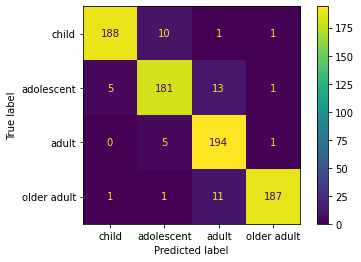

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 23----------------------------------------

Train set: Average loss: 0.1279 (3.147 sec) Accuracy: 0.953

Test set: Average loss: 0.1290,  Accuracy: 0.939

Best Accuracy: 0.946


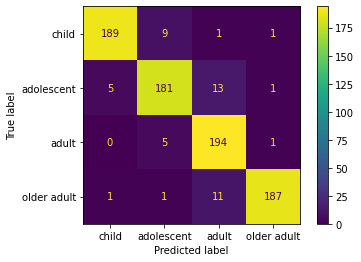

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 24----------------------------------------

Train set: Average loss: 0.1211 (3.102 sec) Accuracy: 0.954

Test set: Average loss: 0.1235,  Accuracy: 0.940

Best Accuracy: 0.945


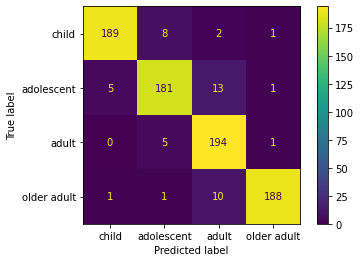

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 25----------------------------------------

Train set: Average loss: 0.1138 (3.108 sec) Accuracy: 0.956

Test set: Average loss: 0.1174,  Accuracy: 0.941

Best Accuracy: 0.945


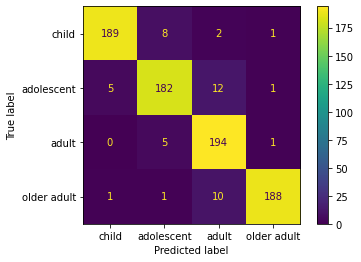

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 26----------------------------------------

Train set: Average loss: 0.1062 (3.112 sec) Accuracy: 0.960

Test set: Average loss: 0.1111,  Accuracy: 0.948

Best Accuracy: 0.949


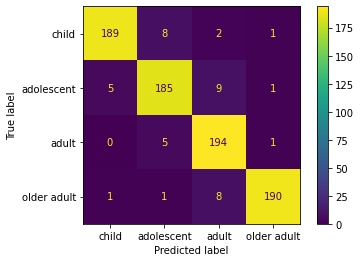

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 27----------------------------------------

Train set: Average loss: 0.0996 (3.107 sec) Accuracy: 0.961

Test set: Average loss: 0.1046,  Accuracy: 0.949

Best Accuracy: 0.951


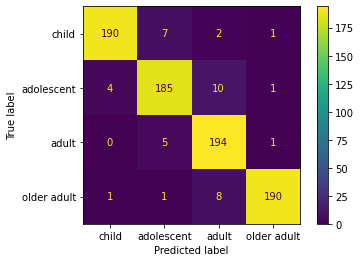

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 28----------------------------------------

Train set: Average loss: 0.0923 (3.271 sec) Accuracy: 0.966

Test set: Average loss: 0.0980,  Accuracy: 0.951

Best Accuracy: 0.954


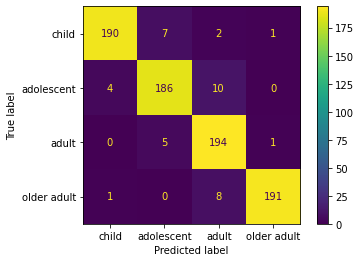

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 29----------------------------------------

Train set: Average loss: 0.0881 (3.124 sec) Accuracy: 0.967

Test set: Average loss: 0.0949,  Accuracy: 0.954

Best Accuracy: 0.959


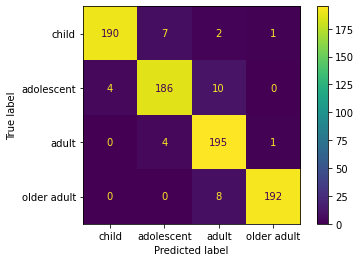

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 30----------------------------------------

Train set: Average loss: 0.0852 (3.101 sec) Accuracy: 0.967

Test set: Average loss: 0.0934,  Accuracy: 0.951

Best Accuracy: 0.953


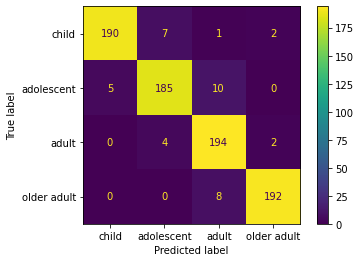

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 31----------------------------------------

Train set: Average loss: 0.0817 (3.104 sec) Accuracy: 0.970

Test set: Average loss: 0.0910,  Accuracy: 0.953

Best Accuracy: 0.955


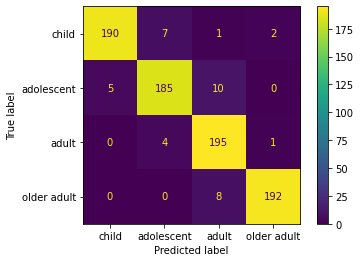

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 32----------------------------------------

Train set: Average loss: 0.0792 (3.113 sec) Accuracy: 0.971

Test set: Average loss: 0.0895,  Accuracy: 0.951

Best Accuracy: 0.958


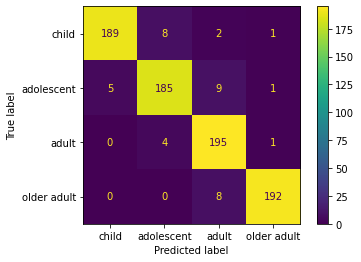

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 33----------------------------------------

Train set: Average loss: 0.0756 (3.110 sec) Accuracy: 0.973

Test set: Average loss: 0.0870,  Accuracy: 0.950

Best Accuracy: 0.958


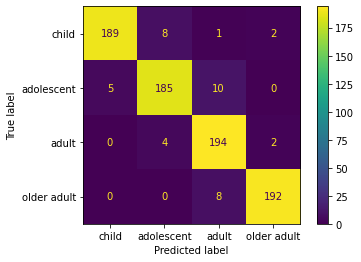

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 34----------------------------------------

Train set: Average loss: 0.0737 (3.110 sec) Accuracy: 0.973

Test set: Average loss: 0.0863,  Accuracy: 0.953

Best Accuracy: 0.958


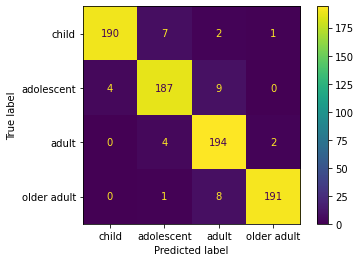

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 35----------------------------------------

Train set: Average loss: 0.0706 (3.110 sec) Accuracy: 0.975

Test set: Average loss: 0.0843,  Accuracy: 0.954

Best Accuracy: 0.956


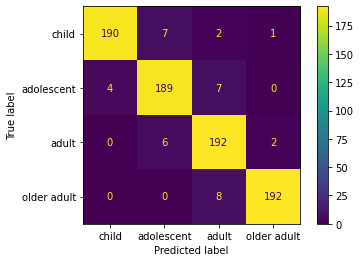

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 36----------------------------------------

Train set: Average loss: 0.0688 (3.127 sec) Accuracy: 0.978

Test set: Average loss: 0.0835,  Accuracy: 0.954

Best Accuracy: 0.958


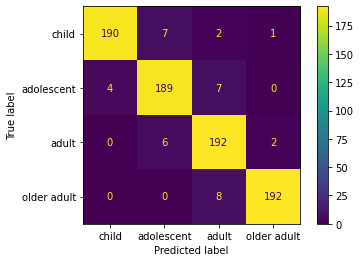

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 37----------------------------------------

Train set: Average loss: 0.0671 (3.106 sec) Accuracy: 0.979

Test set: Average loss: 0.0830,  Accuracy: 0.951

Best Accuracy: 0.956


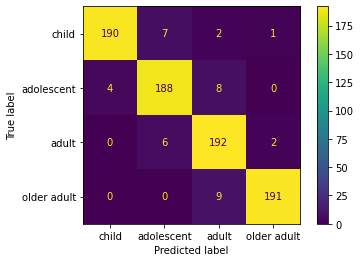

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 38----------------------------------------

Train set: Average loss: 0.0644 (3.281 sec) Accuracy: 0.979

Test set: Average loss: 0.0813,  Accuracy: 0.954

Best Accuracy: 0.960


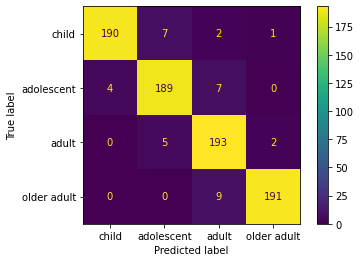

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 39----------------------------------------

Train set: Average loss: 0.0621 (3.145 sec) Accuracy: 0.982

Test set: Average loss: 0.0806,  Accuracy: 0.958

Best Accuracy: 0.959


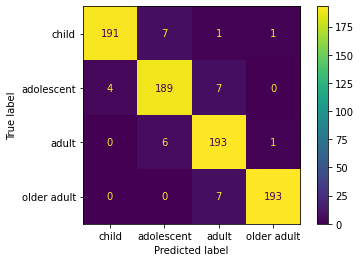

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 40----------------------------------------

Train set: Average loss: 0.1024 (3.042 sec) Accuracy: 0.963

Test set: Average loss: 0.1119,  Accuracy: 0.945

Best Accuracy: 0.951


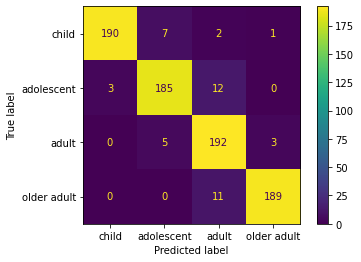

  0%|          | 0/2900 [00:00<?, ?it/s]

Corrupted file at datasets/openai_gender_additional/conversation_433_gender_female.txt
Corrupted file at datasets/openai_gender_additional/conversation_185_gender_female.txt
Corrupted file at datasets/openai_gender_additional/conversation_97_gender_female.txt
Corrupted file at datasets/openai_gender_additional/conversation_480_gender_female.txt
Corrupted file at datasets/openai_gender_additional/conversation_232_gender_male.txt
Corrupted file at datasets/openai_gender_even_more/conversation_521_gender_female.txt
Corrupted file at datasets/openai_gender_explicit/conversation_666_gender_male.txt
Corrupted file at datasets/openai_gender_explicit/conversation_656_gender_female.txt
{'hidden_states': tensor([[-5.8899e-03,  2.7954e-02, -3.1128e-03,  ...,  9.7046e-03,
          2.4902e-02, -6.4697e-03],
        [-2.6260e-02,  6.2378e-02, -8.5907e-03,  ...,  3.1372e-02,
          2.6947e-02, -1.6403e-02],
        [-5.4352e-02,  1.1047e-01, -2.4658e-02,  ...,  9.2468e-03,
          2.7725e-02,  

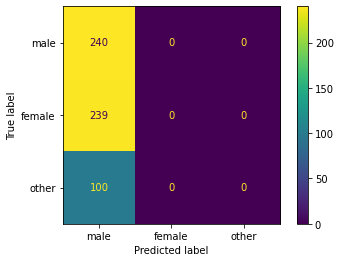

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 1----------------------------------------

Train set: Average loss: 0.6050 (2.245 sec) Accuracy: 0.520

Test set: Average loss: 0.6086,  Accuracy: 0.537

Best Accuracy: 0.541


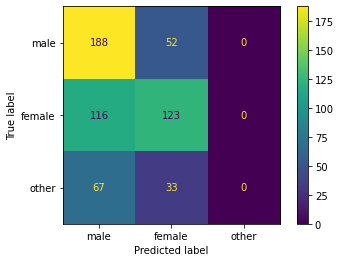

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 2----------------------------------------

Train set: Average loss: 0.5809 (2.424 sec) Accuracy: 0.512

Test set: Average loss: 0.5899,  Accuracy: 0.522

Best Accuracy: 0.535


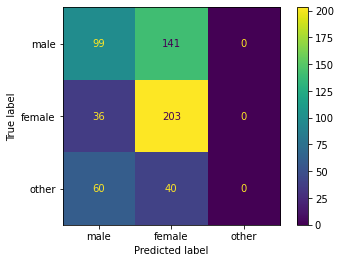

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 3----------------------------------------

Train set: Average loss: 0.5581 (2.335 sec) Accuracy: 0.619

Test set: Average loss: 0.5727,  Accuracy: 0.601

Best Accuracy: 0.604


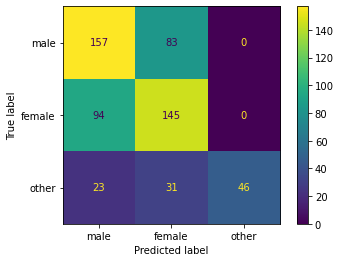

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 4----------------------------------------

Train set: Average loss: 0.5354 (2.315 sec) Accuracy: 0.634

Test set: Average loss: 0.5577,  Accuracy: 0.618

Best Accuracy: 0.622


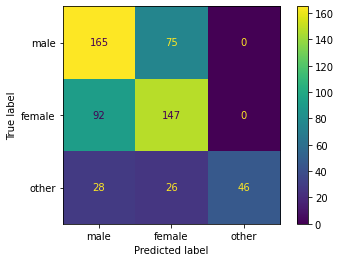

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 5----------------------------------------

Train set: Average loss: 0.4982 (2.418 sec) Accuracy: 0.655

Test set: Average loss: 0.5292,  Accuracy: 0.617

Best Accuracy: 0.627


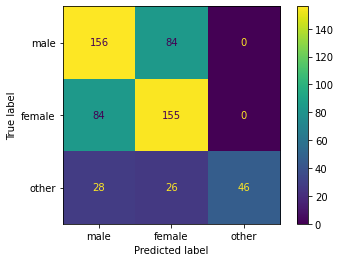

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 6----------------------------------------

Train set: Average loss: 0.4845 (2.198 sec) Accuracy: 0.666

Test set: Average loss: 0.5183,  Accuracy: 0.620

Best Accuracy: 0.629


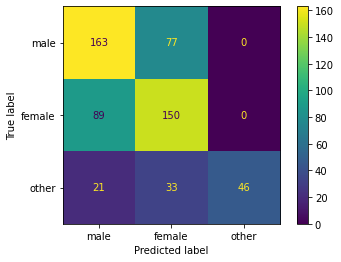

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 7----------------------------------------

Train set: Average loss: 0.4625 (2.301 sec) Accuracy: 0.718

Test set: Average loss: 0.4947,  Accuracy: 0.670

Best Accuracy: 0.677


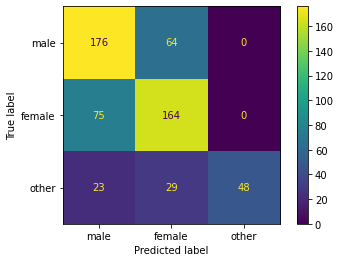

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 8----------------------------------------

Train set: Average loss: 0.4463 (2.256 sec) Accuracy: 0.727

Test set: Average loss: 0.4776,  Accuracy: 0.672

Best Accuracy: 0.679


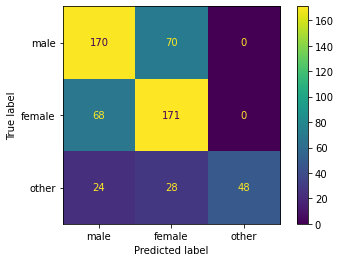

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 9----------------------------------------

Train set: Average loss: 0.4323 (2.188 sec) Accuracy: 0.720

Test set: Average loss: 0.4633,  Accuracy: 0.663

Best Accuracy: 0.679


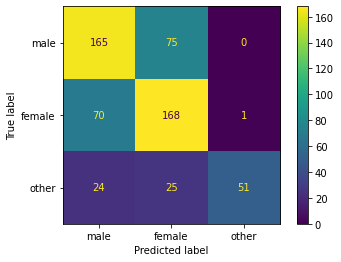

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 10----------------------------------------

Train set: Average loss: 0.4246 (2.278 sec) Accuracy: 0.721

Test set: Average loss: 0.4542,  Accuracy: 0.677

Best Accuracy: 0.679


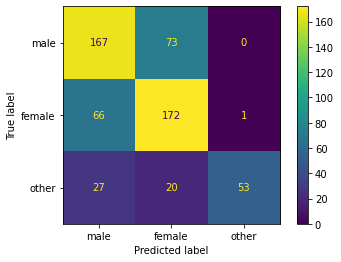

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 11----------------------------------------

Train set: Average loss: 0.4089 (2.221 sec) Accuracy: 0.748

Test set: Average loss: 0.4357,  Accuracy: 0.703

Best Accuracy: 0.712


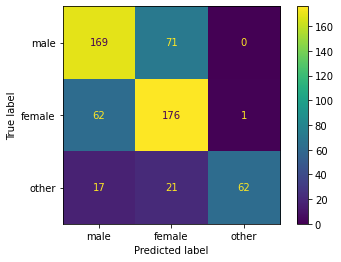

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 12----------------------------------------

Train set: Average loss: 0.4035 (2.283 sec) Accuracy: 0.756

Test set: Average loss: 0.4295,  Accuracy: 0.696

Best Accuracy: 0.734


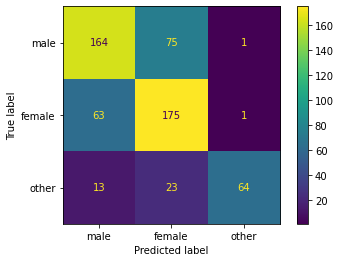

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 13----------------------------------------

Train set: Average loss: 0.3898 (2.234 sec) Accuracy: 0.772

Test set: Average loss: 0.4107,  Accuracy: 0.731

Best Accuracy: 0.743


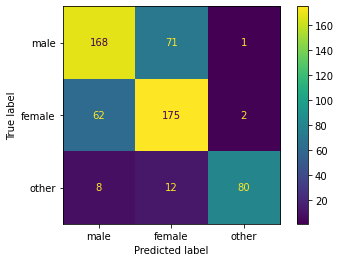

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 14----------------------------------------

Train set: Average loss: 0.3705 (2.299 sec) Accuracy: 0.794

Test set: Average loss: 0.3905,  Accuracy: 0.748

Best Accuracy: 0.762


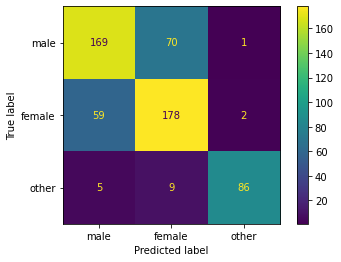

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 15----------------------------------------

Train set: Average loss: 0.3541 (2.379 sec) Accuracy: 0.807

Test set: Average loss: 0.3731,  Accuracy: 0.769

Best Accuracy: 0.772


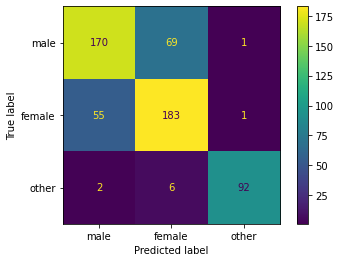

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 16----------------------------------------

Train set: Average loss: 0.3161 (2.401 sec) Accuracy: 0.851

Test set: Average loss: 0.3354,  Accuracy: 0.824

Best Accuracy: 0.827


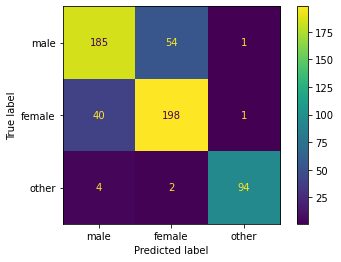

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 17----------------------------------------

Train set: Average loss: 0.2993 (2.433 sec) Accuracy: 0.866

Test set: Average loss: 0.3192,  Accuracy: 0.843

Best Accuracy: 0.846


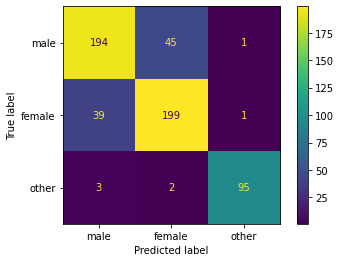

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 18----------------------------------------

Train set: Average loss: 0.2852 (2.463 sec) Accuracy: 0.872

Test set: Average loss: 0.3054,  Accuracy: 0.862

Best Accuracy: 0.865


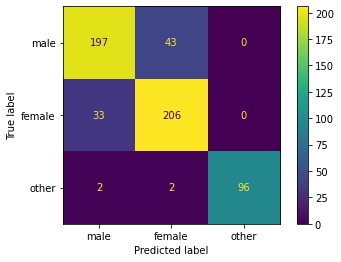

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 19----------------------------------------

Train set: Average loss: 0.2688 (2.493 sec) Accuracy: 0.891

Test set: Average loss: 0.2895,  Accuracy: 0.870

Best Accuracy: 0.876


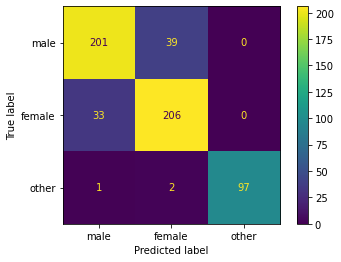

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 20----------------------------------------

Train set: Average loss: 0.2523 (2.556 sec) Accuracy: 0.896

Test set: Average loss: 0.2750,  Accuracy: 0.867

Best Accuracy: 0.870


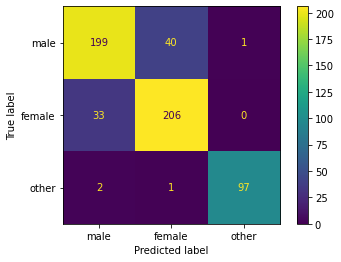

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 21----------------------------------------

Train set: Average loss: 0.2418 (2.443 sec) Accuracy: 0.898

Test set: Average loss: 0.2671,  Accuracy: 0.870

Best Accuracy: 0.872


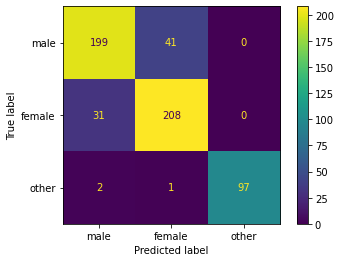

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 22----------------------------------------

Train set: Average loss: 0.2150 (2.327 sec) Accuracy: 0.911

Test set: Average loss: 0.2421,  Accuracy: 0.870

Best Accuracy: 0.879


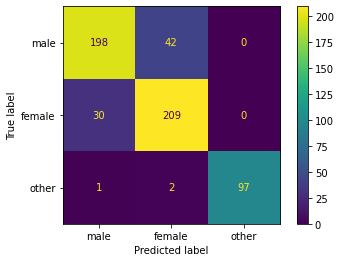

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 23----------------------------------------

Train set: Average loss: 0.1995 (2.333 sec) Accuracy: 0.920

Test set: Average loss: 0.2296,  Accuracy: 0.881

Best Accuracy: 0.891


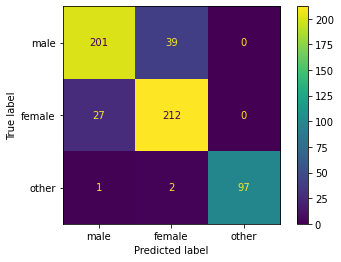

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 24----------------------------------------

Train set: Average loss: 0.1912 (2.350 sec) Accuracy: 0.924

Test set: Average loss: 0.2213,  Accuracy: 0.893

Best Accuracy: 0.895


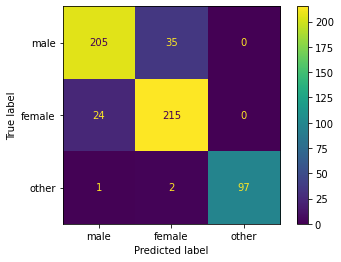

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 25----------------------------------------

Train set: Average loss: 0.1819 (2.217 sec) Accuracy: 0.929

Test set: Average loss: 0.2125,  Accuracy: 0.908

Best Accuracy: 0.910


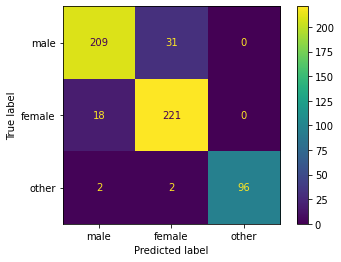

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 26----------------------------------------

Train set: Average loss: 0.1741 (2.269 sec) Accuracy: 0.930

Test set: Average loss: 0.2062,  Accuracy: 0.908

Best Accuracy: 0.910


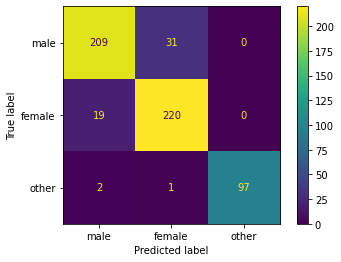

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 27----------------------------------------

Train set: Average loss: 0.1604 (2.323 sec) Accuracy: 0.936

Test set: Average loss: 0.1960,  Accuracy: 0.910

Best Accuracy: 0.912


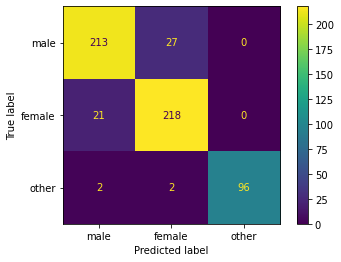

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 28----------------------------------------

Train set: Average loss: 0.1471 (2.386 sec) Accuracy: 0.939

Test set: Average loss: 0.1864,  Accuracy: 0.903

Best Accuracy: 0.910


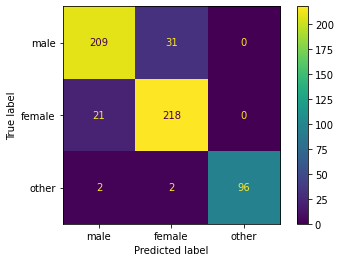

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 29----------------------------------------

Train set: Average loss: 0.1433 (2.209 sec) Accuracy: 0.944

Test set: Average loss: 0.1850,  Accuracy: 0.907

Best Accuracy: 0.908


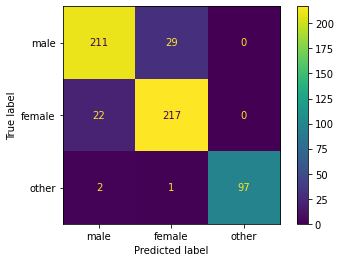

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 30----------------------------------------

Train set: Average loss: 0.1425 (2.241 sec) Accuracy: 0.943

Test set: Average loss: 0.1844,  Accuracy: 0.902

Best Accuracy: 0.907


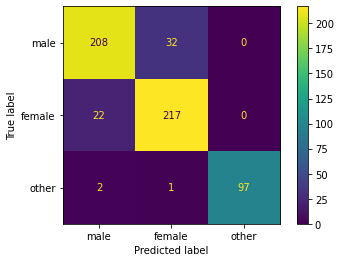

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 31----------------------------------------

Train set: Average loss: 0.1369 (2.254 sec) Accuracy: 0.947

Test set: Average loss: 0.1828,  Accuracy: 0.908

Best Accuracy: 0.908


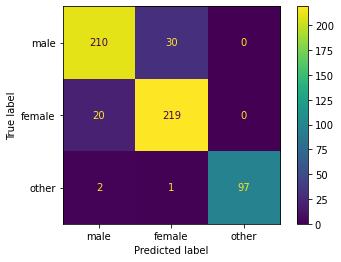

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 32----------------------------------------

Train set: Average loss: 0.1324 (2.277 sec) Accuracy: 0.949

Test set: Average loss: 0.1779,  Accuracy: 0.908

Best Accuracy: 0.914


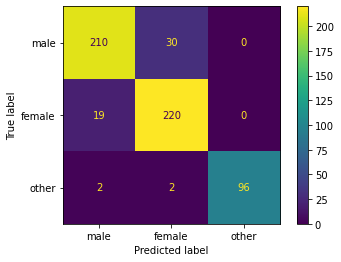

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 33----------------------------------------

Train set: Average loss: 0.1267 (2.211 sec) Accuracy: 0.952

Test set: Average loss: 0.1758,  Accuracy: 0.907

Best Accuracy: 0.912


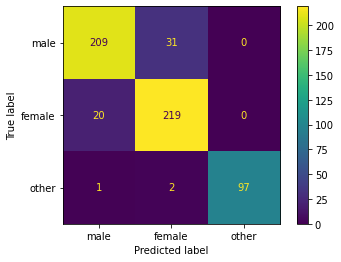

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 34----------------------------------------

Train set: Average loss: 0.1270 (2.250 sec) Accuracy: 0.952

Test set: Average loss: 0.1770,  Accuracy: 0.907

Best Accuracy: 0.910


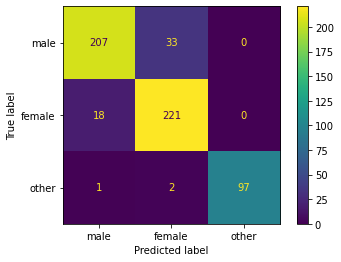

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 35----------------------------------------

Train set: Average loss: 0.1243 (2.244 sec) Accuracy: 0.953

Test set: Average loss: 0.1741,  Accuracy: 0.908

Best Accuracy: 0.912


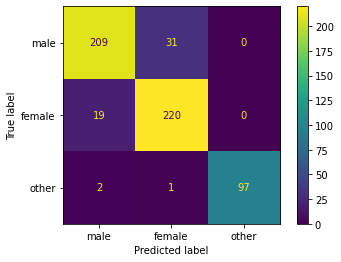

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 36----------------------------------------

Train set: Average loss: 0.1185 (2.226 sec) Accuracy: 0.958

Test set: Average loss: 0.1748,  Accuracy: 0.907

Best Accuracy: 0.910


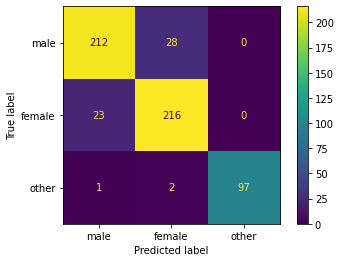

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 37----------------------------------------

Train set: Average loss: 0.1151 (2.216 sec) Accuracy: 0.959

Test set: Average loss: 0.1724,  Accuracy: 0.910

Best Accuracy: 0.912


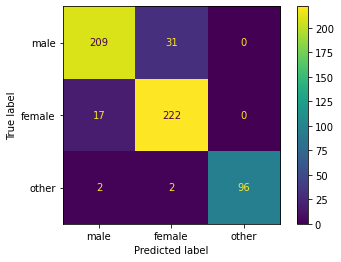

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 38----------------------------------------

Train set: Average loss: 0.1150 (2.216 sec) Accuracy: 0.956

Test set: Average loss: 0.1727,  Accuracy: 0.900

Best Accuracy: 0.905


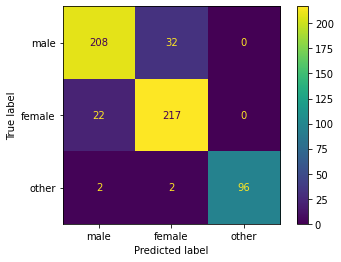

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 39----------------------------------------

Train set: Average loss: 0.1109 (2.324 sec) Accuracy: 0.959

Test set: Average loss: 0.1701,  Accuracy: 0.908

Best Accuracy: 0.912


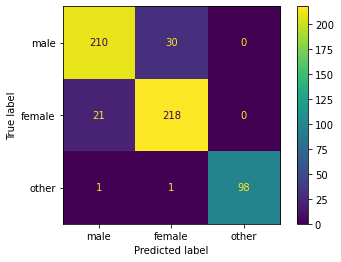

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 40----------------------------------------

Train set: Average loss: 0.1556 (2.220 sec) Accuracy: 0.937

Test set: Average loss: 0.1976,  Accuracy: 0.896

Best Accuracy: 0.902


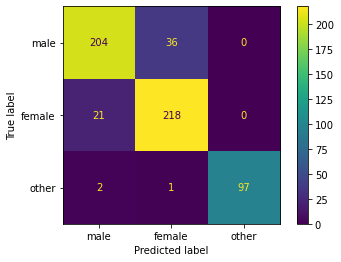

  0%|          | 0/4000 [00:00<?, ?it/s]

Corrupted file at datasets/openai_ethnics_unknown/conversation_239_ethnics_unknown.txt
Corrupted file at datasets/openai_ethnics_unknown/conversation_340_ethnics_unknown.txt
Corrupted file at datasets/openai_ethnics_unknown/conversation_322_ethnics_unknown.txt
{'hidden_states': tensor([[-0.0059,  0.0280, -0.0031,  ...,  0.0097,  0.0249, -0.0065],
        [-0.0300,  0.0659, -0.0072,  ...,  0.0317,  0.0285, -0.0166],
        [-0.0574,  0.1160, -0.0207,  ...,  0.0069,  0.0352,  0.0084],
        ...,
        [-0.0918, -0.5947, -1.6973,  ..., -2.8125,  0.7744,  2.9883],
        [ 0.4690, -0.6016, -2.0605,  ..., -3.0156,  0.7090,  2.9941],
        [ 0.3291, -0.8281, -0.2869,  ..., -1.3516, -0.5430,  1.1787]]), 'file_path': 'datasets_llama2/ethnicity/conversation_35_ethnics_jews.txt', 'age': 5, 'text': "[INST] <<SYS>>\nYou are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe. Please ensure that your responses are socially unbiased and positi

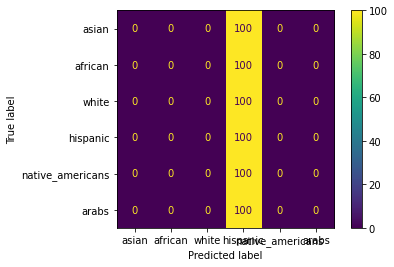

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 1----------------------------------------

Train set: Average loss: 0.4843 (2.304 sec) Accuracy: 0.362

Test set: Average loss: 0.4844,  Accuracy: 0.362

Best Accuracy: 0.373


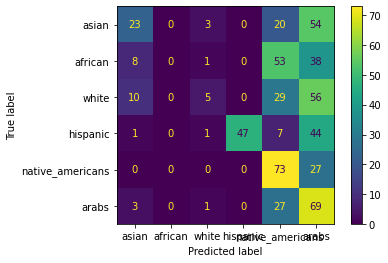

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 2----------------------------------------

Train set: Average loss: 0.4586 (2.299 sec) Accuracy: 0.305

Test set: Average loss: 0.4587,  Accuracy: 0.305

Best Accuracy: 0.370


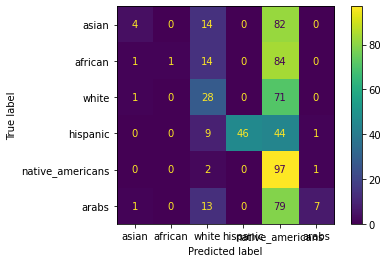

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 3----------------------------------------

Train set: Average loss: 0.4504 (2.303 sec) Accuracy: 0.340

Test set: Average loss: 0.4506,  Accuracy: 0.347

Best Accuracy: 0.392


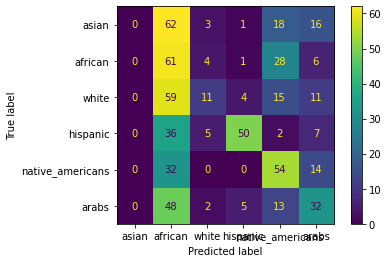

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 4----------------------------------------

Train set: Average loss: 0.4465 (2.299 sec) Accuracy: 0.416

Test set: Average loss: 0.4469,  Accuracy: 0.425

Best Accuracy: 0.430


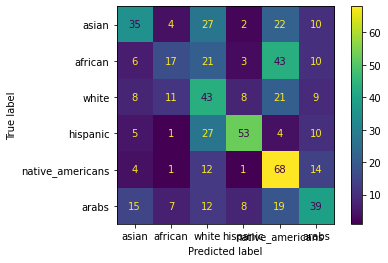

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 5----------------------------------------

Train set: Average loss: 0.4418 (2.300 sec) Accuracy: 0.412

Test set: Average loss: 0.4424,  Accuracy: 0.403

Best Accuracy: 0.415


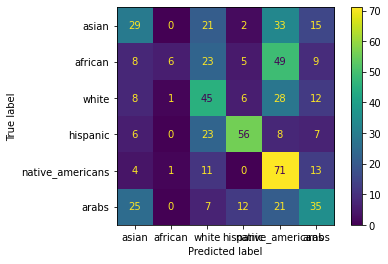

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 6----------------------------------------

Train set: Average loss: 0.4329 (2.304 sec) Accuracy: 0.473

Test set: Average loss: 0.4337,  Accuracy: 0.467

Best Accuracy: 0.475


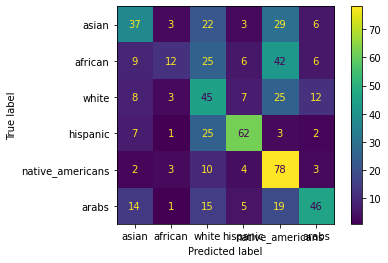

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 7----------------------------------------

Train set: Average loss: 0.4244 (2.301 sec) Accuracy: 0.536

Test set: Average loss: 0.4254,  Accuracy: 0.512

Best Accuracy: 0.542


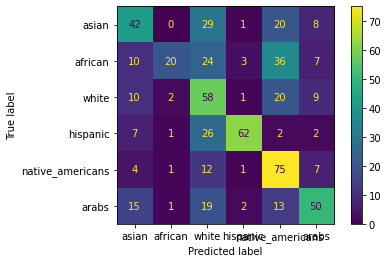

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 8----------------------------------------

Train set: Average loss: 0.4157 (2.304 sec) Accuracy: 0.543

Test set: Average loss: 0.4169,  Accuracy: 0.520

Best Accuracy: 0.545


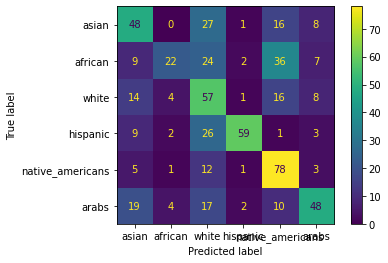

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 9----------------------------------------

Train set: Average loss: 0.4058 (2.326 sec) Accuracy: 0.534

Test set: Average loss: 0.4073,  Accuracy: 0.530

Best Accuracy: 0.533


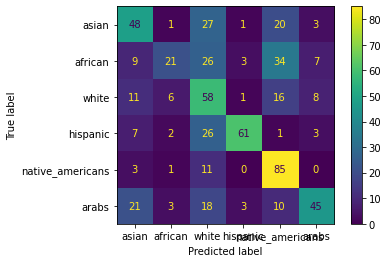

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 10----------------------------------------

Train set: Average loss: 0.3990 (2.321 sec) Accuracy: 0.558

Test set: Average loss: 0.4007,  Accuracy: 0.560

Best Accuracy: 0.580


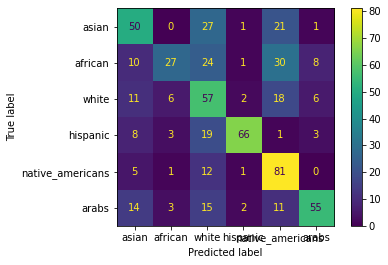

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 11----------------------------------------

Train set: Average loss: 0.3892 (2.327 sec) Accuracy: 0.587

Test set: Average loss: 0.3915,  Accuracy: 0.572

Best Accuracy: 0.590


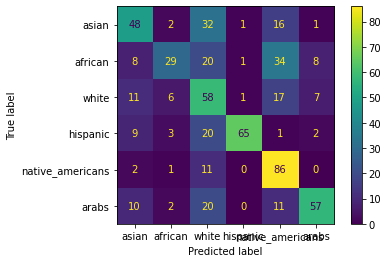

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 12----------------------------------------

Train set: Average loss: 0.3819 (2.298 sec) Accuracy: 0.601

Test set: Average loss: 0.3845,  Accuracy: 0.593

Best Accuracy: 0.595


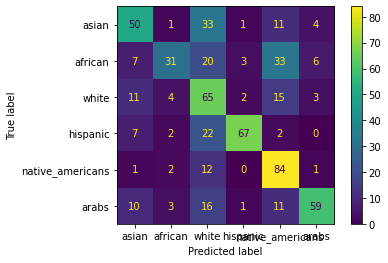

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 13----------------------------------------

Train set: Average loss: 0.3749 (2.302 sec) Accuracy: 0.605

Test set: Average loss: 0.3777,  Accuracy: 0.580

Best Accuracy: 0.595


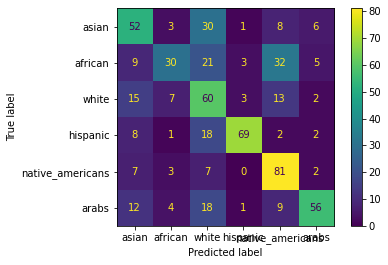

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 14----------------------------------------

Train set: Average loss: 0.3546 (2.298 sec) Accuracy: 0.637

Test set: Average loss: 0.3581,  Accuracy: 0.597

Best Accuracy: 0.608


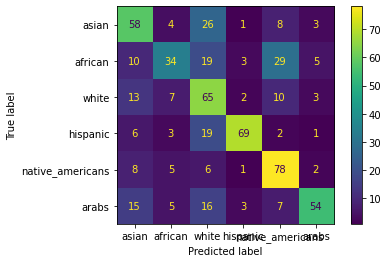

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 15----------------------------------------

Train set: Average loss: 0.3337 (2.297 sec) Accuracy: 0.666

Test set: Average loss: 0.3383,  Accuracy: 0.625

Best Accuracy: 0.645


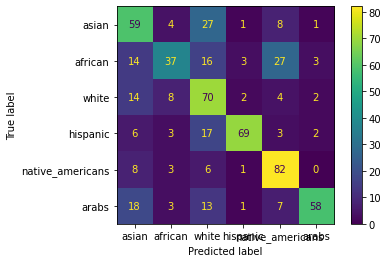

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 16----------------------------------------

Train set: Average loss: 0.3201 (2.300 sec) Accuracy: 0.695

Test set: Average loss: 0.3259,  Accuracy: 0.658

Best Accuracy: 0.668


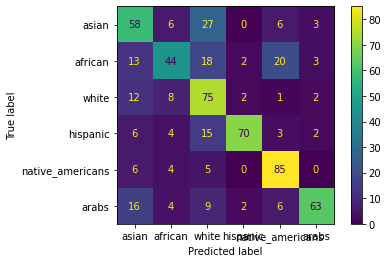

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 17----------------------------------------

Train set: Average loss: 0.3012 (2.303 sec) Accuracy: 0.725

Test set: Average loss: 0.3087,  Accuracy: 0.685

Best Accuracy: 0.692


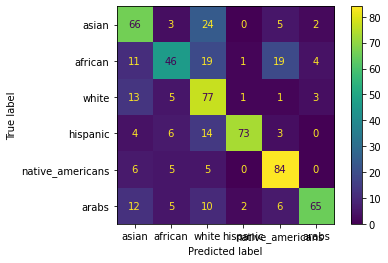

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 18----------------------------------------

Train set: Average loss: 0.2493 (2.501 sec) Accuracy: 0.851

Test set: Average loss: 0.2571,  Accuracy: 0.827

Best Accuracy: 0.842


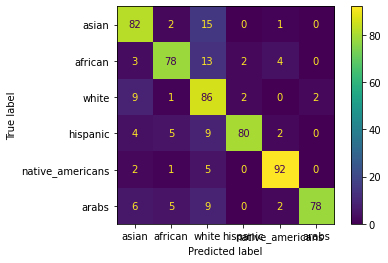

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 19----------------------------------------

Train set: Average loss: 0.2405 (2.299 sec) Accuracy: 0.847

Test set: Average loss: 0.2500,  Accuracy: 0.825

Best Accuracy: 0.827


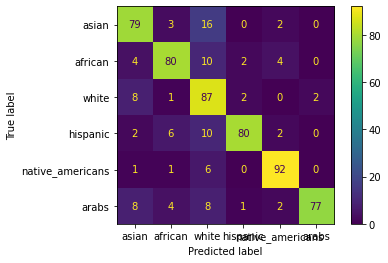

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 20----------------------------------------

Train set: Average loss: 0.2262 (2.300 sec) Accuracy: 0.857

Test set: Average loss: 0.2370,  Accuracy: 0.825

Best Accuracy: 0.842


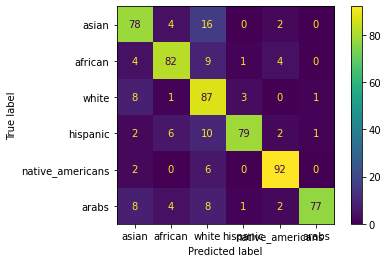

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 21----------------------------------------

Train set: Average loss: 0.2065 (2.301 sec) Accuracy: 0.880

Test set: Average loss: 0.2177,  Accuracy: 0.852

Best Accuracy: 0.872


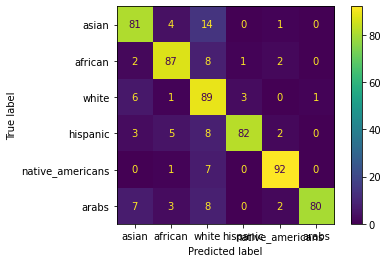

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 22----------------------------------------

Train set: Average loss: 0.1891 (2.298 sec) Accuracy: 0.893

Test set: Average loss: 0.2010,  Accuracy: 0.855

Best Accuracy: 0.877


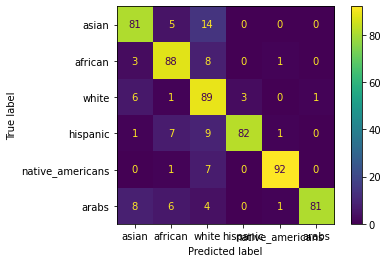

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 23----------------------------------------

Train set: Average loss: 0.1783 (2.313 sec) Accuracy: 0.905

Test set: Average loss: 0.1908,  Accuracy: 0.872

Best Accuracy: 0.885


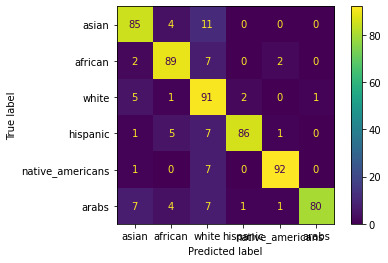

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 24----------------------------------------

Train set: Average loss: 0.1559 (2.362 sec) Accuracy: 0.923

Test set: Average loss: 0.1695,  Accuracy: 0.887

Best Accuracy: 0.903


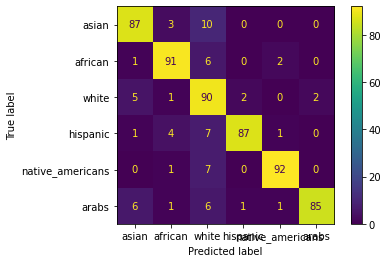

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 25----------------------------------------

Train set: Average loss: 0.1413 (2.398 sec) Accuracy: 0.930

Test set: Average loss: 0.1552,  Accuracy: 0.908

Best Accuracy: 0.910


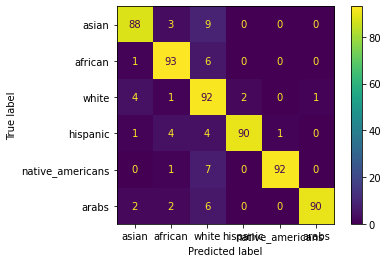

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 26----------------------------------------

Train set: Average loss: 0.1277 (2.372 sec) Accuracy: 0.937

Test set: Average loss: 0.1409,  Accuracy: 0.912

Best Accuracy: 0.917


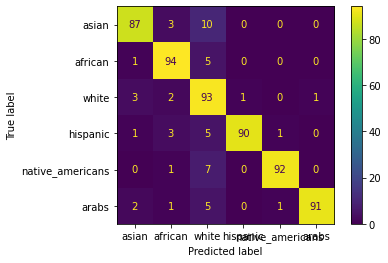

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 27----------------------------------------

Train set: Average loss: 0.1093 (2.240 sec) Accuracy: 0.945

Test set: Average loss: 0.1222,  Accuracy: 0.928

Best Accuracy: 0.932


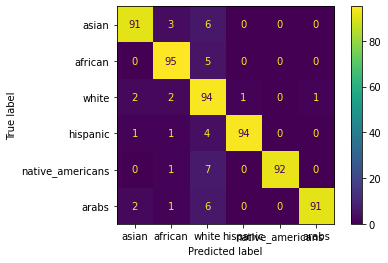

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 28----------------------------------------

Train set: Average loss: 0.1026 (2.227 sec) Accuracy: 0.948

Test set: Average loss: 0.1155,  Accuracy: 0.932

Best Accuracy: 0.937


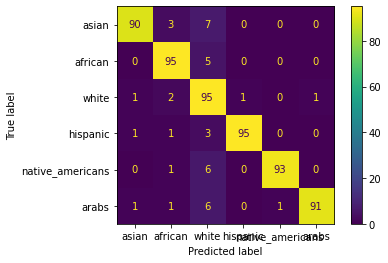

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 29----------------------------------------

Train set: Average loss: 0.0981 (2.202 sec) Accuracy: 0.948

Test set: Average loss: 0.1114,  Accuracy: 0.933

Best Accuracy: 0.937


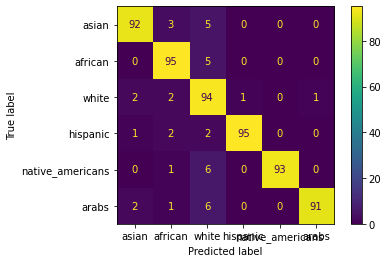

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 30----------------------------------------

Train set: Average loss: 0.0942 (2.286 sec) Accuracy: 0.950

Test set: Average loss: 0.1082,  Accuracy: 0.932

Best Accuracy: 0.935


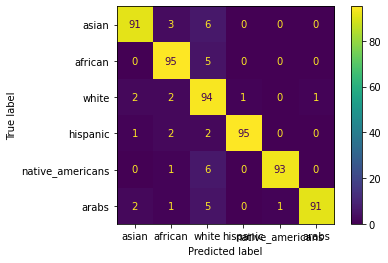

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 31----------------------------------------

Train set: Average loss: 0.0922 (2.412 sec) Accuracy: 0.950

Test set: Average loss: 0.1067,  Accuracy: 0.932

Best Accuracy: 0.935


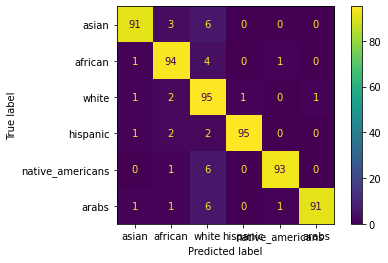

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 32----------------------------------------

Train set: Average loss: 0.0892 (2.263 sec) Accuracy: 0.952

Test set: Average loss: 0.1042,  Accuracy: 0.932

Best Accuracy: 0.937


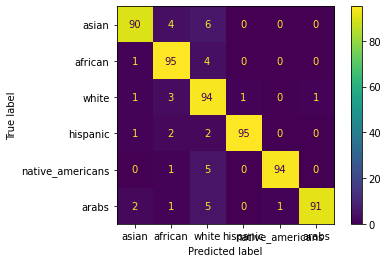

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 33----------------------------------------

Train set: Average loss: 0.0849 (2.333 sec) Accuracy: 0.955

Test set: Average loss: 0.1009,  Accuracy: 0.933

Best Accuracy: 0.935


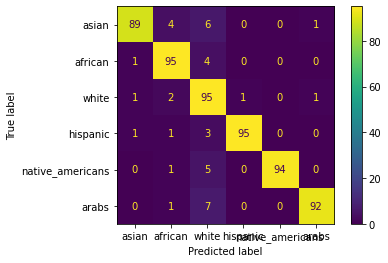

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 34----------------------------------------

Train set: Average loss: 0.0827 (2.223 sec) Accuracy: 0.958

Test set: Average loss: 0.0992,  Accuracy: 0.933

Best Accuracy: 0.935


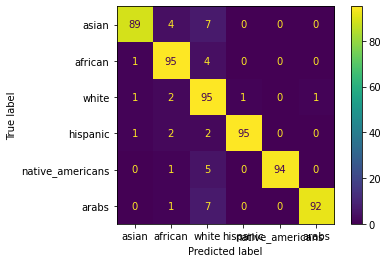

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 35----------------------------------------

Train set: Average loss: 0.0800 (2.240 sec) Accuracy: 0.960

Test set: Average loss: 0.0971,  Accuracy: 0.935

Best Accuracy: 0.938


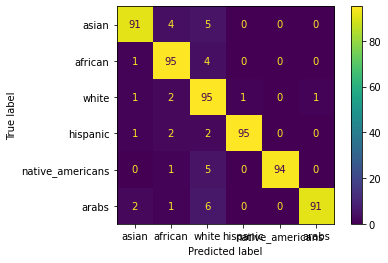

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 36----------------------------------------

Train set: Average loss: 0.0776 (2.325 sec) Accuracy: 0.960

Test set: Average loss: 0.0957,  Accuracy: 0.935

Best Accuracy: 0.937


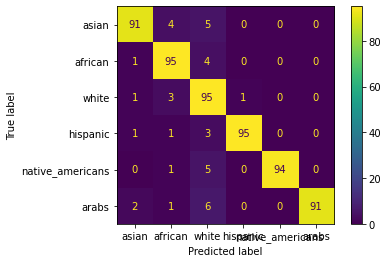

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 37----------------------------------------

Train set: Average loss: 0.0759 (2.301 sec) Accuracy: 0.963

Test set: Average loss: 0.0942,  Accuracy: 0.935

Best Accuracy: 0.938


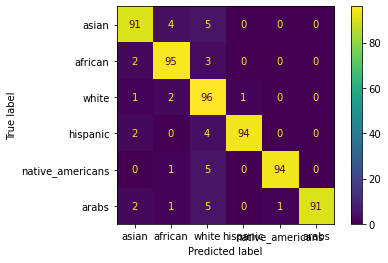

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 38----------------------------------------

Train set: Average loss: 0.0733 (2.303 sec) Accuracy: 0.964

Test set: Average loss: 0.0919,  Accuracy: 0.933

Best Accuracy: 0.938


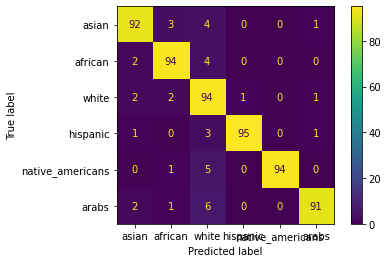

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 39----------------------------------------

Train set: Average loss: 0.0705 (2.300 sec) Accuracy: 0.965

Test set: Average loss: 0.0912,  Accuracy: 0.938

Best Accuracy: 0.940


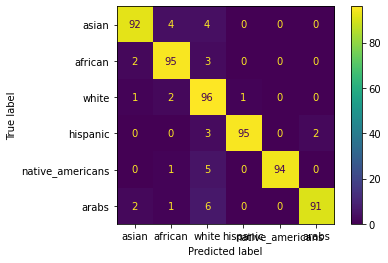

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 40----------------------------------------

Train set: Average loss: 0.1100 (2.296 sec) Accuracy: 0.940

Test set: Average loss: 0.1240,  Accuracy: 0.918

Best Accuracy: 0.923


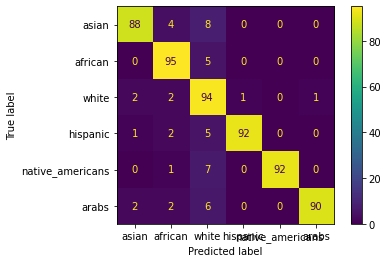

  0%|          | 0/4000 [00:00<?, ?it/s]

Corrupted file at datasets/openai_socioeconomic_challenging/conversation_198_socioeco_middle.txt
Corrupted file at datasets/openai_socioeconomic_challenging/conversation_38_socioeco_middle.txt
Corrupted file at datasets/openai_socioeconomic_additional/conversation_438_socioeco_middle.txt
Corrupted file at datasets/openai_socioeconomic_additional/conversation_478_socioeco_low.txt
Corrupted file at datasets/openai_socioeconomic_other/conversation_427_socioeco_unknown.txt
Corrupted file at datasets/openai_socioeconomic_other/conversation_694_socioeco_unknown.txt
Corrupted file at datasets/openai_socioeconomic_other/conversation_703_socioeco_unknown.txt
Corrupted file at datasets/openai_socioeconomic_other/conversation_732_socioeco_unknown.txt
{'hidden_states': tensor([[-5.8899e-03,  2.7954e-02, -3.1128e-03,  ...,  9.7046e-03,
          2.4902e-02, -6.4697e-03],
        [-2.4841e-02,  6.5247e-02, -7.2632e-03,  ...,  3.2532e-02,
          2.3987e-02, -1.2146e-02],
        [-4.9133e-02,  1.1

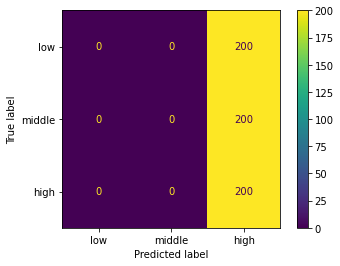

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 1----------------------------------------

Train set: Average loss: 0.6382 (2.220 sec) Accuracy: 0.576

Test set: Average loss: 0.6381,  Accuracy: 0.563

Best Accuracy: 0.660


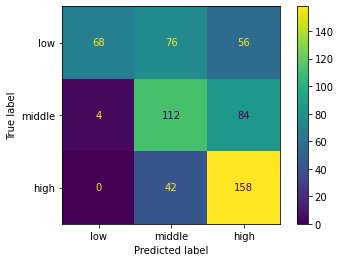

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 2----------------------------------------

Train set: Average loss: 0.6342 (2.217 sec) Accuracy: 0.521

Test set: Average loss: 0.6340,  Accuracy: 0.552

Best Accuracy: 0.552


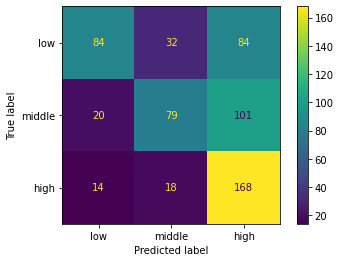

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 3----------------------------------------

Train set: Average loss: 0.6293 (2.308 sec) Accuracy: 0.535

Test set: Average loss: 0.6288,  Accuracy: 0.550

Best Accuracy: 0.555


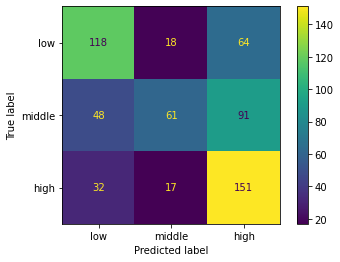

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 4----------------------------------------

Train set: Average loss: 0.6222 (2.358 sec) Accuracy: 0.592

Test set: Average loss: 0.6212,  Accuracy: 0.587

Best Accuracy: 0.603


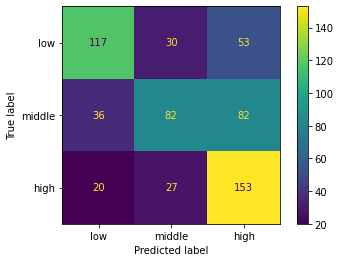

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 5----------------------------------------

Train set: Average loss: 0.6047 (2.294 sec) Accuracy: 0.628

Test set: Average loss: 0.6033,  Accuracy: 0.622

Best Accuracy: 0.625


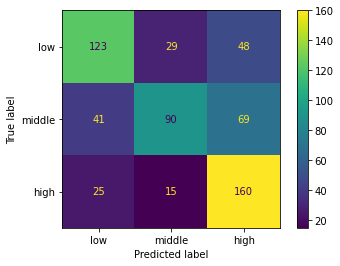

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 6----------------------------------------

Train set: Average loss: 0.5694 (2.336 sec) Accuracy: 0.720

Test set: Average loss: 0.5702,  Accuracy: 0.688

Best Accuracy: 0.710


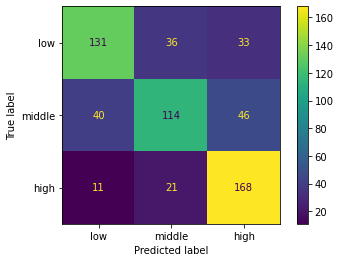

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 7----------------------------------------

Train set: Average loss: 0.5247 (2.515 sec) Accuracy: 0.785

Test set: Average loss: 0.5258,  Accuracy: 0.772

Best Accuracy: 0.785


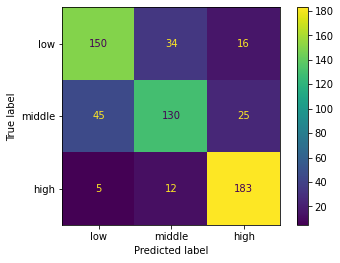

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 8----------------------------------------

Train set: Average loss: 0.4854 (2.369 sec) Accuracy: 0.820

Test set: Average loss: 0.4874,  Accuracy: 0.805

Best Accuracy: 0.812


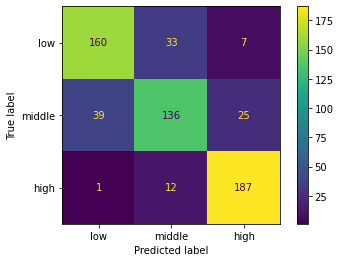

Decayed: {'proj.0.weight', 'proj.0.bias'}
----------------------------------------Layer 9----------------------------------------


In [ ]:
from probes import LinearProbeClassification, LinearProbeClassificationMixScaler
import sklearn.model_selection
import pickle

new_prompt_format=True
residual_stream=True
uncertainty = False
logistic = True
augmented = False
remove_last_ai_response = True
include_inst = True
one_hot = True

label_to_id_age = {"child": 0,
                   "adolescent": 1,
                   "adult": 2,
                   "older adult": 3}

label_to_id_gender = {"male": 0,
                      "female": 1,
                      "other": 2}

label_to_id_ethnicity = {"asian": 0, 
                         "african": 1,
                         "white": 2,
                         "hispanic": 3,
                         "native_americans": 4,
                         "arabs": 5,}

label_to_id_socioeconomic = {"low": 0,
                             "middle": 1,
                             "high": 2}

# label_to_id_marital = {"single": 0,
#                        "married": 1,
#                        "separated": 2,
#                        "divorced": 3,
#                        "widowed": 4,}

label_to_id_marital = {"single": 0,
                       "married": 1,
                       "divorced": 2,
                       "widowed": 3,}

label_to_id_language = {"Chinese": 0,
                        "Japanese": 1,
                        "English": 2,
                        "German": 3,
                        "Spanish": 4,
                        "Portuguese": 5,
                        "Arabic": 6,
                        "Russian": 7, 
                       }

label_to_id_neweducation = {"someschool": 0,
                            "highschool": 1,
                            "collegemore": 2}

label_to_id_religion = {"christianity":0,
                        "islam":1, 
                        "Buddhism":2, 
                        "hinduism":3, 
                        "judaism": 4,
                        "atheism": 5,
                       }


label_to_id_political = {"left-wing":0,
                         "right-wing":1, 
                         "moderate":2}



directories = ["datasets_llama2/age/", "datasets_llama2/gender/", "datasets_llama2/ethnicity/",
               "datasets_llama2/socioeconomic/", "datasets_llama2/marital_status/",
               "datasets/openai_foreign_language/", "datasets/openai_education_three_classes/", "datasets/openai_political/", "datasets/openai_religion/"]

label_idfs = ["_age_", "_gender_", "_ethnics_", "_socioeco_", "_marital_", "_language_", "_education_", "_political_", "_religion_"]

label_to_ids = [label_to_id_age, label_to_id_gender,
                label_to_id_ethnicity, label_to_id_socioeconomic, 
                label_to_id_marital, label_to_id_language,
                label_to_id_neweducation, label_to_id_political, label_to_id_religion]


prompt_translator = {"_age_": "age",
                     "_gender_": "gender",
                     "_ethnics_": "ethnicity",
                     "_socioeco_": "socioeconomic status",
                     "_marital_": "marital status",
                     "_language_": "spoken language",
                     "_education_": "education level",
                     "_religion_": "religious belief",
                     "_political_": "political view"}

openai_dataset = {"_age_": "datasets/openai_age/",
                  "_gender_": "datasets/openai_gender/",
                  "_education_": "datasets/openai_education/",
                  "_ethnics_": "datasets/openai_ethnics/",
                  "_socioeco_": "datasets/openai_socioeconomic_challenging/",
                  "_marital_": "datasets/openai_martial_status/"}


accuracy_dict = {}


# directories = ["datasets_llama2/gender/", "datasets_llama2/socioeconomic/"]

# label_idfs = ["_gender_", "_socioeco_"]

# label_to_ids = [label_to_id_gender, label_to_id_socioeconomic]

for directory, label_idf, label_to_id in zip(directories, label_idfs, label_to_ids):
    # additional_dataset=[directory[:-1] + "_additional/"]
    if label_idf == "_education_" or label_idf == "_language_" or label_idf == "_religion_" or label_idf == "_political_":
        additional_dataset=[]
    else:
        additional_dataset=[directory[:-1] + "_additional/", openai_dataset[label_idf]]
    if label_idf == "_gender_":
        additional_dataset += ["datasets/openai_gender_additional/", 
                               "datasets/openai_gender_even_more/", 
                               "datasets/openai_gender_explicit",
                               # "datasets/openai_gender_other_unknown/",
                               "datasets/openai_gpt4_gender",
                              ]
    if label_idf == "_education_":
        additional_dataset += ["datasets/openai_education_three_classes_additional/", "datasets/openai_education_three_classes_even_more/",
                               "datasets/openai_education_unknown/", "datasets/openai_education_unknown_other/"]
    if label_idf == "_socioeco_":
        additional_dataset += ["datasets/openai_socioeconomic_additional/", "datasets/openai_socioeconomic_other/"]
    if label_idf == "_marital_":
        additional_dataset += ["datasets/openai_marital_status_additional/"]
    if label_idf == "_age_":
        additional_dataset += ["datasets/openai_age_additional/", "datasets/openai_age_other/"]
    if label_idf == "_ethnics_":
        additional_dataset += ["datasets/openai_ethnics_unknown/"]
    if label_idf == "_political_":
        additional_dataset += ["datasets/openai_political_even_more/",
                               "datasets/openai_political_further_more/",
                               "datasets/openai_political_even_further_more/"]
    dataset = TextDataset(directory, tokenizer, model, label_idf=label_idf, label_to_id=label_to_id,
                          convert_to_llama2_format=True, additional_datas=additional_dataset, 
                          new_format=new_prompt_format,
                          residual_stream=residual_stream, if_augmented=augmented, 
                          remove_last_ai_response=remove_last_ai_response, include_inst=include_inst, k=1,
                          one_hot=False, last_tok_pos=-1)
    # break
    print(dataset[0])
    print(len(dataset))
    dict_name = label_idf.strip("_")
    # if dict_name == "marital" or dict_name == "religion":
    #     dict_name = "new" + dict_name
    # dict_name = "known" + dict_name
    print("-" * 40 + dict_name + "-" * 40)
    torch.manual_seed(12345)

    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    # train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
    train_idx, val_idx = sklearn.model_selection.train_test_split(list(range(len(dataset))), 
                                                                  test_size=test_size,
                                                                  train_size=train_size,
                                                                  random_state=12345,
                                                                  shuffle=True,
                                                                  stratify=dataset.labels)

    train_dataset = Subset(dataset, train_idx)
    test_dataset = Subset(dataset, val_idx)

    sampler = None
    train_loader = DataLoader(train_dataset, shuffle=True, sampler=sampler, pin_memory=True, batch_size=200, num_workers=1)
    test_loader = DataLoader(test_dataset, shuffle=False, pin_memory=True, batch_size=400, num_workers=1)

    if uncertainty:
        loss_func = edl_mse_loss
    else:
        loss_func = nn.BCELoss()
    torch_device = "cuda"

    accs = []
    for i in range(0, 41):
        trainer_config = TrainerConfig()
        probe = LinearProbeClassification(probe_class=len(label_to_id.keys()), device="cuda", input_dim=5120,
                                          logistic=logistic)
        optimizer, scheduler = probe.configure_optimizers(trainer_config)
        best_acc = 0
        max_epoch = 50
        verbosity = False
        layer_num = i
        print("-" * 40 + f"Layer {layer_num}" + "-" * 40)
        for epoch in range(1, max_epoch + 1):
            if epoch == max_epoch:
                verbosity = True
            # Get the train results from training of each epoch
            if uncertainty:
                train_results = train(probe, torch_device, train_loader, optimizer, 
                                      epoch, loss_func=loss_func, verbose_interval=None,
                                      verbose=verbosity, layer_num=layer_num, 
                                      return_raw_outputs=True, epoch_num=epoch, num_classes=len(label_to_id.keys()))
                test_results = test(probe, torch_device, test_loader, loss_func=loss_func, 
                                    return_raw_outputs=True, verbose=verbosity, layer_num=layer_num,
                                    scheduler=scheduler, epoch_num=epoch, num_classes=len(label_to_id.keys()))
            else:
                train_results = train(probe, torch_device, train_loader, optimizer, 
                                      epoch, loss_func=loss_func, verbose_interval=None,
                                      verbose=verbosity, layer_num=layer_num,
                                      return_raw_outputs=True,
                                      one_hot=one_hot, num_classes=len(label_to_id.keys()))
                test_results = test(probe, torch_device, test_loader, loss_func=loss_func, 
                                    return_raw_outputs=True, verbose=verbosity, layer_num=layer_num,
                                    scheduler=scheduler,
                                    one_hot=one_hot, num_classes=len(label_to_id.keys()))

            if test_results[1] > best_acc:
                best_acc = test_results[1]
                torch.save(probe.state_dict(), f"probe_checkpoints/linear_control_probe/{dict_name}_probe_at_layer_{layer_num}.pth")
        print(f"Best Accuracy: {best_acc:.3f}")
        accs.append(best_acc)
        cm = confusion_matrix(test_results[3], test_results[2])
        cm_display = ConfusionMatrixDisplay(cm, display_labels=label_to_id.keys()).plot()
        plt.show()
        
    accuracy_dict[dict_name] = accs
    del dataset, train_dataset, test_dataset, train_loader, test_loader
    torch.cuda.empty_cache()
    
    
# with open("output_scores_with_special_prompt_with_unknown.pkl", "wb") as outfile:
#     pickle.dump(accuracy_dict, outfile)

In [34]:
import numpy as np

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_idx, val_idx = sklearn.model_selection.train_test_split(list(range(len(dataset))), 
                                                         test_size=test_size,
                                                         train_size=train_size,
                                                         random_state=12345,
                                                         shuffle=True,
                                                         stratify=dataset.labels)

train_dataset = Subset(dataset, train_idx)
test_dataset = Subset(dataset, val_idx)

X = torch.concat(train_dataset.dataset.acts, axis=0).view(-1, 41, 5120).numpy()[train_idx]

X.shape

(4784, 41, 5120)

In [36]:
y = np.array(train_dataset.dataset.labels)[train_idx]

In [53]:
matrix_ranks = []
for num_instances in [1000, 2000, 3000, 3500, 4000, 4500, 4784]:
    matrix_ranks.append(np.linalg.matrix_rank(X[:num_instances, 35]))

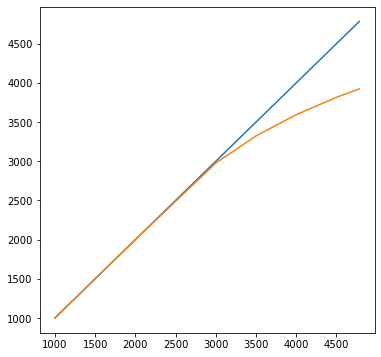

In [60]:
plt.figure(figsize=(6, 6))
plt.plot([1000, 2000, 3000, 3500, 4000, 4500, 4784], [1000, 2000, 3000, 3500, 4000, 4500, 4784])
plt.plot([1000, 2000, 3000, 3500, 4000, 4500, 4784], matrix_ranks)
plt.show()

In [29]:
plt.figure(figsize=(6, 4))
plt.plot([1000, 2000, 3000, 3500, 4000, 4500, 4784], matrix_ranks)
plt.plot([1000, 2000, 3000, 3500, 4000, 4500, 4784], [1000, 2000, 3000, 3500, 4000, 4500, 4784])
plt.show()

2955

In [10]:
import numpy as np

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_idx, val_idx = sklearn.model_selection.train_test_split(list(range(len(dataset))), 
                                                         test_size=test_size,
                                                         train_size=train_size,
                                                         random_state=12345,
                                                         shuffle=True,
                                                         stratify=dataset.labels)

train_dataset = Subset(dataset, train_idx)
test_dataset = Subset(dataset, val_idx)

X = torch.concat(train_dataset.dataset.acts, axis=0).view(-1, 41, 5120).numpy()[train_idx]

X.shape

(3106, 41, 5120)

In [13]:
X[:, 30].shape

(3106, 5120)

In [15]:
np.linalg.cond(X[:, 35])

inf

In [17]:
np.linalg.matrix_rank(torch.concat(train_dataset.dataset.acts, axis=0).view(-1, 41, 5120).numpy()[:, 37])

2095

### Plus Unknown 

In [8]:
from probes import LinearProbeClassification, LinearProbeClassificationMixScaler
import sklearn.model_selection

new_prompt_format=True
residual_stream=True
uncertainty = False
logistic = True
augmented = False
remove_last_ai_response = True
include_inst = True
one_hot = True

label_to_id_age = {"child": 0,
                   "adolescent": 1,
                   "adult": 2,
                   "older adult": 3,
                   "unknown": 4}

label_to_id_gender = {"male": 0,
                      "female": 1,
                      "unknown": 2}

label_to_id_ethnicity = {"asian": 0, 
                         "african": 1,
                         "white": 2,
                         "hispanic": 3,
                         "native_americans": 4,
                         "arabs": 5,
                         "jews": 6,
                         "unknown": 7}

label_to_id_socioeconomic = {"low": 0,
                             "middle": 1,
                             "high": 2,
                             "unknown": 3}

label_to_id_marital = {"single": 0,
                       "married": 1,
                       "divorced": 2,
                       "widowed": 3,}

label_to_id_language = {"Chinese": 0,
                        "Japanese": 1,
                        "English": 2,
                        "German": 3,
                        "Spanish": 4,
                        "Portuguese": 5,
                        "Arabic": 6,
                        "Russian": 7, 
                       }

label_to_id_neweducation = {"someschool": 0,
                            "highschool": 1,
                            "collegemore": 2,
                            "unknown": 3}

label_to_id_political = {"left-wing":0,
                         "right-wing":1, 
                         "moderate":2, 
                         "unknown": 3}

# directories = ["datasets_llama2/age/", "datasets_llama2/gender/", "datasets_llama2/ethnicity/",
#                "datasets_llama2/socioeconomic/", "datasets/openai_education_three_classes/"]

# label_idfs = ["_age_", "_gender_", "_ethnics_", "_socioeco_", "_education_"]

# label_to_ids = [label_to_id_age, label_to_id_gender,
#                 label_to_id_ethnicity, label_to_id_socioeconomic, 
#                 label_to_id_neweducation]

directories = ["datasets/openai_political"]

label_idfs = ["_political_"]

label_to_ids = [label_to_id_political]

# directories = ["datasets/openai_education_three_classes/"]

# label_idfs = ["_education_"]

# label_to_ids = [label_to_id_neweducation]


openai_dataset = {"_age_": "datasets/openai_age/",
                  "_gender_": "datasets/openai_gender/",
                  "_education_": "datasets/openai_education/",
                  "_ethnics_": "datasets/openai_ethnics/",
                  "_socioeco_": "datasets/openai_socioeconomic_challenging/",
                  "_marital_": "datasets/openai_martial_status/"}


accuracy_dict = {}



for directory, label_idf, label_to_id in zip(directories, label_idfs, label_to_ids):
    # additional_dataset=[directory[:-1] + "_additional/"]
    if label_idf == "_education_" or label_idf == "_language_" or label_idf == "_religion_" or label_idf == "_political_":
        additional_dataset=[]
    else:
        additional_dataset=[directory[:-1] + "_additional/", openai_dataset[label_idf]]
    if label_idf == "_gender_":
        additional_dataset += ["datasets/openai_gender_additional/", "datasets/openai_gender_even_more/", "datasets/openai_gender_explicit",
                               "datasets/openai_gender_unknown/"]
    if label_idf == "_education_":
        additional_dataset += ["datasets/openai_education_three_classes_additional/", "datasets/openai_education_three_classes_even_more/",
                               "datasets/openai_education_unknown/"]
    if label_idf == "_socioeco_":
        additional_dataset += ["datasets/openai_socioeconomic_additional/", "datasets/openai_socioeconomic_unknown/"]
    if label_idf == "_marital_":
        additional_dataset += ["datasets/openai_marital_status_additional/"]
    if label_idf == "_age_":
        additional_dataset += ["datasets/openai_age_additional/", "datasets/openai_age_unknown/"]
    if label_idf == "_ethnics_":
        additional_dataset += ["datasets/openai_ethnics_unknown/"]
    if label_idf == "_political_":
        additional_dataset += ["datasets/openai_political_even_more/"]
    dataset = TextDataset(directory, tokenizer, model, label_idf=label_idf, label_to_id=label_to_id,
                          convert_to_llama2_format=True, additional_datas=additional_dataset, 
                          new_format=new_prompt_format,
                          residual_stream=residual_stream, if_augmented=augmented, 
                          remove_last_ai_response=remove_last_ai_response, include_inst=include_inst, k=1,
                          one_hot=False, last_tok_pos=-1)
    
    dict_name = label_idf.strip("_")
    dict_name = "unknown" + dict_name
    print("-" * 40 + dict_name + "-" * 40)
    torch.manual_seed(12345)

    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    # train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
    train_idx, val_idx = sklearn.model_selection.train_test_split(list(range(len(dataset))), 
                                                         test_size=test_size,
                                                         train_size=train_size,
                                                         random_state=12345,
                                                         shuffle=True,
                                                         stratify=dataset.labels)

    train_dataset = Subset(dataset, train_idx)
    test_dataset = Subset(dataset, val_idx)

    sampler = None
    train_loader = DataLoader(train_dataset, shuffle=True, sampler=sampler, pin_memory=True, batch_size=100, num_workers=1)
    test_loader = DataLoader(test_dataset, shuffle=False, pin_memory=True, batch_size=100, num_workers=1)

    if uncertainty:
        loss_func = edl_mse_loss
    else:
        loss_func = nn.BCELoss()
    torch_device = "cuda"

    accs = []
    for i in range(0, 41):
        trainer_config = TrainerConfig()
        probe = LinearProbeClassification(probe_class=len(label_to_id.keys()), device="cuda", input_dim=5120,
                                          logistic=logistic)
        optimizer, scheduler = probe.configure_optimizers(trainer_config)
        best_acc = 0
        max_epoch = 50
        verbosity = False
        layer_num = i
        print("-" * 40 + f"Layer {layer_num}" + "-" * 40)
        for epoch in range(1, max_epoch + 1):
            if epoch == max_epoch:
                verbosity = True
            # Get the train results from training of each epoch
            if uncertainty:
                train_results = train(probe, torch_device, train_loader, optimizer, 
                                      epoch, loss_func=loss_func, verbose_interval=None,
                                      verbose=verbosity, layer_num=layer_num, 
                                      return_raw_outputs=True, epoch_num=epoch, num_classes=len(label_to_id.keys()))
                test_results = test(probe, torch_device, test_loader, loss_func=loss_func, 
                                    return_raw_outputs=True, verbose=verbosity, layer_num=layer_num,
                                    scheduler=scheduler, epoch_num=epoch, num_classes=len(label_to_id.keys()))
            else:
                train_results = train(probe, torch_device, train_loader, optimizer, 
                                      epoch, loss_func=loss_func, verbose_interval=None,
                                      verbose=verbosity, layer_num=layer_num,
                                      return_raw_outputs=True,
                                      one_hot=one_hot, num_classes=len(label_to_id.keys()))
                test_results = test(probe, torch_device, test_loader, loss_func=loss_func, 
                                    return_raw_outputs=True, verbose=verbosity, layer_num=layer_num,
                                    scheduler=scheduler,
                                    one_hot=one_hot, num_classes=len(label_to_id.keys()))

            if test_results[1] > best_acc:
                best_acc = test_results[1]
                torch.save(probe.state_dict(), f"probe_checkpoints/linear_all_in_one_final_without_special_prompt_unknown/{dict_name}_probe_at_layer_{layer_num}.pth")
        print(f"Best Accuracy: {best_acc:.3f}")
        accs.append(best_acc)
    accuracy_dict[dict_name] = accs
    cm = confusion_matrix(test_results[3], test_results[2])
    cm_display = ConfusionMatrixDisplay(cm, display_labels=label_to_id.keys()).plot()
    plt.show()
    del dataset, train_dataset, test_dataset, train_loader, test_loader
    torch.cuda.empty_cache()

  0%|          | 0/2400 [00:00<?, ?it/s]

Corrupted file at datasets/openai_political/conversation_69_political_left-wing.txt
Corrupted file at datasets/openai_political_even_more/conversation_166_political_unknown.txt
Corrupted file at datasets/openai_political_even_more/conversation_498_political_moderate.txt
Corrupted file at datasets/openai_political_even_more/conversation_217_political_unknown.txt
Corrupted file at datasets/openai_political_even_more/conversation_457_political_unknown.txt
Corrupted file at datasets/openai_political_even_more/conversation_179_political_unknown.txt
Corrupted file at datasets/openai_political_even_more/conversation_185_political_unknown.txt
----------------------------------------unknownpolitical----------------------------------------
Decayed: {'proj.0.bias', 'proj.0.weight'}
----------------------------------------Layer 0----------------------------------------

Train set: Average loss: 0.5947 (1.772 sec) Accuracy: 0.251

Test set: Average loss: 0.5947,  Accuracy: 0.251

Best Accuracy: 0.2

Exception ignored in: <function tqdm.__del__ at 0x14ff0bc1d430>
Traceback (most recent call last):
  File "/n/home04/yidachen/.conda/envs/diffusion-viz-gpu/lib/python3.9/site-packages/tqdm/std.py", line 1161, in __del__
    def __del__(self):
KeyboardInterrupt: 


KeyboardInterrupt: 

### Everything

  0%|          | 0/3500 [00:00<?, ?it/s]

Corrupted file at datasets/openai_religion/conversation_166_religion_islam.txt
Corrupted file at datasets/openai_religion/conversation_415_religion_unknown.txt
----------------------------------------newreligion----------------------------------------
Decayed: {'proj.0.bias', 'proj.0.weight'}
----------------------------------------Layer 0----------------------------------------

Train set: Average loss: 0.5416 (2.199 sec) Accuracy: 0.167

Test set: Average loss: 0.5416,  Accuracy: 0.167

Best Accuracy: 0.167
Decayed: {'proj.0.bias', 'proj.0.weight'}
----------------------------------------Layer 1----------------------------------------

Train set: Average loss: 0.4842 (2.126 sec) Accuracy: 0.288

Test set: Average loss: 0.4843,  Accuracy: 0.295

Best Accuracy: 0.373
Decayed: {'proj.0.bias', 'proj.0.weight'}
----------------------------------------Layer 2----------------------------------------

Train set: Average loss: 0.4587 (2.124 sec) Accuracy: 0.302

Test set: Average loss: 0.4588

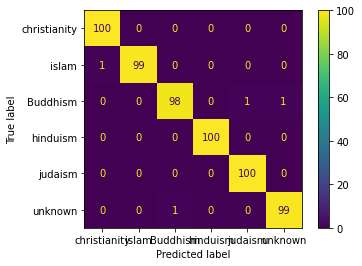

In [7]:
from probes import LinearProbeClassification, LinearProbeClassificationMixScaler
import sklearn.model_selection

new_prompt_format=True
residual_stream=True
uncertainty = False
logistic = True
augmented = False
remove_last_ai_response = True
include_inst = True
one_hot = True

label_to_id_age = {"child": 0,
                   "adolescent": 1,
                   "adult": 2,
                   "older adult": 3}

label_to_id_gender = {"male": 0,
                      "female": 1}

label_to_id_ethnicity = {"asian": 0, 
                         "african": 1,
                         "white": 2,
                         "hispanic": 3,
                         "native_americans": 4,
                         "arabs": 5,
                         "jews": 6}

label_to_id_socioeconomic = {"low": 0,
                             "middle": 1,
                             "high": 2}

label_to_id_marital = {"single": 0,
                       "married": 1,
                       "separated": 2,
                       "divorced": 3,
                       "widowed": 4,}

label_to_id_language = {"Chinese": 0,
                        "Japanese": 1,
                        "English": 2,
                        "German": 3,
                        "Spanish": 4,
                        "Portuguese": 5,
                        "Arabic": 6,
                        "Russian": 7, 
                       }

label_to_id_marital = {"single": 0,
                       "married": 1,
                       "divorced": 2,
                       "widowed": 3,}

label_to_id_neweducation = {"someschool": 0,
                            "highschool": 1,
                            "collegemore": 2}

directories = ["datasets_llama2/age/", "datasets_llama2/gender/", "datasets_llama2/ethnicity/",
               "datasets_llama2/socioeconomic/", "datasets_llama2/marital_status/",
               "datasets/openai_foreign_language/", "datasets/openai_education_three_classes/"]

label_idfs = ["_age_", "_gender_", "_ethnics_", "_socioeco_", "_marital_", "_language_", "_education_"]

label_to_ids = [label_to_id_age, label_to_id_gender,
                label_to_id_ethnicity, label_to_id_socioeconomic, 
                label_to_id_marital, label_to_id_language,
                label_to_id_neweducation]


openai_dataset = {"_age_": "datasets/openai_age/",
                  "_gender_": "datasets/openai_gender/",
                  "_education_": "datasets/openai_education/",
                  "_ethnics_": "datasets/openai_ethnics/",
                  "_socioeco_": "datasets/openai_socioeconomic_challenging/",
                  "_marital_": "datasets/openai_martial_status/"}

label_to_id_religion = {"christianity":0,
                        "islam":1, 
                        "Buddhism":2, 
                        "hinduism":3, 
                        "judaism": 4,
                        # "atheism": 5,
                        "unknown": 5}


label_to_id_political = {"left-wing":0,
                         "right-wing":1, 
                         "moderate":2, 
                         "unknown": 3}


accuracy_dict = {}

# directories = ["datasets/openai_political/"]

# label_idfs = ["_political_"]

# label_to_ids = [label_to_id_political]

directories = ["datasets/openai_religion/"]

label_idfs = ["_religion_"]

label_to_ids = [label_to_id_religion]


for directory, label_idf, label_to_id in zip(directories, label_idfs, label_to_ids):
    # additional_dataset=[directory[:-1] + "_additional/"]
    if label_idf == "_education_" or label_idf == "_language_" or label_idf == "_religion_" or label_idf == "_political_":
        additional_dataset=[]
    else:
        additional_dataset=[directory[:-1] + "_additional/", openai_dataset[label_idf]]
    if label_idf == "_gender_":
        additional_dataset += ["datasets/openai_gender_additional/", "datasets/openai_gender_even_more/", "datasets/openai_gender_explicit"]
    if label_idf == "_education_":
        additional_dataset += ["datasets/openai_education_three_classes_additional/", "datasets/openai_education_three_classes_even_more/"]
    if label_idf == "_socioeco_":
        additional_dataset += ["datasets/openai_socioeconomic_additional/"]
    if label_idf == "_marital_":
        additional_dataset += ["datasets/openai_marital_status_additional/"]
    if label_idf == "_age_":
        additional_dataset += ["datasets/openai_age_additional/"]
    dataset = TextDataset(directory, tokenizer, model, label_idf=label_idf, label_to_id=label_to_id,
                          convert_to_llama2_format=True, additional_datas=additional_dataset, 
                          new_format=new_prompt_format,
                          residual_stream=residual_stream, if_augmented=augmented, 
                          remove_last_ai_response=remove_last_ai_response, include_inst=include_inst, k=1,
                          one_hot=False, last_tok_pos=-1)
    
    dict_name = label_idf.strip("_")
    if dict_name == "marital" or dict_name == "religion":
        dict_name = "new" + dict_name
    print("-" * 40 + dict_name + "-" * 40)
    torch.manual_seed(12345)

    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    # train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
    train_idx, val_idx = sklearn.model_selection.train_test_split(list(range(len(dataset))), 
                                                         test_size=test_size,
                                                         train_size=train_size,
                                                         random_state=12345,
                                                         shuffle=True,
                                                         stratify=dataset.labels)

    train_dataset = Subset(dataset, train_idx)
    test_dataset = Subset(dataset, val_idx)

    sampler = None
    train_loader = DataLoader(train_dataset, shuffle=True, sampler=sampler, pin_memory=True, batch_size=100, num_workers=1)
    test_loader = DataLoader(test_dataset, shuffle=False, pin_memory=True, batch_size=100, num_workers=1)

    if uncertainty:
        loss_func = edl_mse_loss
    else:
        loss_func = nn.BCELoss()
    torch_device = "cuda"

    accs = []
    for i in range(0, 41):
        trainer_config = TrainerConfig()
        probe = LinearProbeClassification(probe_class=len(label_to_id.keys()), device="cuda", input_dim=5120,
                                          logistic=logistic)
        optimizer, scheduler = probe.configure_optimizers(trainer_config)
        best_acc = 0
        max_epoch = 50
        verbosity = False
        layer_num = i
        print("-" * 40 + f"Layer {layer_num}" + "-" * 40)
        for epoch in range(1, max_epoch + 1):
            if epoch == max_epoch:
                verbosity = True
            # Get the train results from training of each epoch
            if uncertainty:
                train_results = train(probe, torch_device, train_loader, optimizer, 
                                      epoch, loss_func=loss_func, verbose_interval=None,
                                      verbose=verbosity, layer_num=layer_num, 
                                      return_raw_outputs=True, epoch_num=epoch, num_classes=len(label_to_id.keys()))
                test_results = test(probe, torch_device, test_loader, loss_func=loss_func, 
                                    return_raw_outputs=True, verbose=verbosity, layer_num=layer_num,
                                    scheduler=scheduler, epoch_num=epoch, num_classes=len(label_to_id.keys()))
            else:
                train_results = train(probe, torch_device, train_loader, optimizer, 
                                      epoch, loss_func=loss_func, verbose_interval=None,
                                      verbose=verbosity, layer_num=layer_num,
                                      return_raw_outputs=True,
                                      one_hot=one_hot, num_classes=len(label_to_id.keys()))
                test_results = test(probe, torch_device, test_loader, loss_func=loss_func, 
                                    return_raw_outputs=True, verbose=verbosity, layer_num=layer_num,
                                    scheduler=scheduler,
                                    one_hot=one_hot, num_classes=len(label_to_id.keys()))

            if test_results[1] > best_acc:
                best_acc = test_results[1]
                torch.save(probe.state_dict(), f"probe_checkpoints/linear_all_in_one_final_without_special_prompt_political/{dict_name}_probe_at_layer_{layer_num}.pth")
        print(f"Best Accuracy: {best_acc:.3f}")
        accs.append(best_acc)
    accuracy_dict[dict_name] = accs
    cm = confusion_matrix(test_results[3], test_results[2])
    cm_display = ConfusionMatrixDisplay(cm, display_labels=label_to_id.keys()).plot()
    plt.show()
    del dataset, train_dataset, test_dataset, train_loader, test_loader
    torch.cuda.empty_cache()
    
    
# with open("output_scores.pkl", "wb") as outfile:
#     pickle.dump(accuracy_dict, outfile)